After we have manually labelled the data, we first check to see how the models are doing with the improved labels. This is so that we can compare our accuracies obtained now to the ones obtained previously by using the original labels. If the accuracies are higher, then we can conclude that our hard work of manual labelling the data has paid off. The process for running the models will be similar to what we have done earlier.

# Importing the dataframe

In [ ]:
import os
os.chdir('/content/drive/My Drive/Capstone')

Commodity Title (Editted) is the column which we manually tagged each row. Normalized UNSPSC (Editted) is the column which we will fill in if our tagged label is a new one.

In [ ]:
import pandas as pd

overall_df = pd.read_csv('fiscal_y1.csv')
overall_df = overall_df[['Item Name', 'Item Description', 'Commodity Title (Editted)', 'Commodity Title', 'Normalized UNSPSC (Editted)', 'Normalized UNSPSC']]

# Running models after manual labelling

## Pre-processing

Steps involved here:

    1. Clean the class labels

    2. Removing rows which have empty Item Name and Item Description

    3. Concatenating the Item Name and Item Description Columns so that we do not need to have 2 bags of words later.

    4. Text Cleaning

      - Remove Punctuation
      - Lowercase all the words
      - Tokenize the texts, meaning that each word will become a token
      - Removing stopwords. Stopwords are commonly used words such as 'the', 'she', 'he'.
      - Lemmatizing. Group words to a similar word. For example, 'good', 'better' and 'best' will be changed to 'good'.
      - Stemming. To convert the words to their root form. For example, 'eating' will be changed to 'eat'.
      - Removing special characters, such as '$', '%'
      - Removing numbers
      - Removing line breaks. They will appear as '\r' or '\n' in the text.
      - Removing single character. They are probably just typos.

Step 1: Cleaning of class labels

We noticed that there are some rows with spacing as well as \t and \n in the labels. We need to clean them so that the model will not treat the label with a spacing as a different label.

In [ ]:
for index, row in overall_df.iterrows():
  label = str(row['Commodity Title'])
  if '\t' in label:
    overall_df.at[index, 'Commodity Title'] = str(row['Commodity Title']).replace('\t', '')
  if '\n' in label:
    overall_df.at[index, 'Commodity Title'] = str(row['Commodity Title']).replace('\n', '')
  overall_df.at[index, 'Commodity Title'] = str(row['Commodity Title']).strip(' ')

The code below describes steps 2 and 3.

In [ ]:
texts = []
classes = []
for index, row in overall_df.iterrows():
  classname = row['Commodity Title (Editted)']
  if len(str(row['Item Name'])) == 0 and len(str(row['Item Description'])) == 0: #whole row is empty
    continue
  if pd.isna(row['Item Description']): #keeping only 1 of the columns if the other column is empty
    text = str(row['Item Name'])
  elif pd.isna(row['Item Name']):
    text = str(row['Item Description'])
  else:
    text = str(row['Item Name']) + " " + str(row['Item Description']) #concatenate both text columns to form just 1 column
  if not pd.isna(classname) and not pd.isna(text): #only want rows with non-empty classes and non-empty text
    texts.append(text)
    classes.append(classname)

df = pd.DataFrame()
df['Class'] = classes
df['Text'] = texts

df.head()

Step 4: Text Cleaning

We will write a function so that it is easier to automate the text cleaning later.

In [ ]:
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
nltk.download('wordnet')

def text_cleaning(dataframe):
  new_df = pd.DataFrame()
  texts = []
  classes = []
  tokenizer = RegexpTokenizer(r'\w+')
  stopwords_lst = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()
  stemmer = PorterStemmer()
  for index, row in dataframe.iterrows():
    text = row['Text']
    #remove punctuation
    text = ''.join([i for i in text if i not in string.punctuation])
    #lowercase 
    text = ''.join([i.lower() for i in text])
    #tokenize
    text = ' '.join(tokenizer.tokenize(text))
    #remove stopwords
    text = ' '.join([i for i in text.split() if i not in stopwords_lst])
    #lemmatize
    text = ' '.join([lemmatizer.lemmatize(i) for i in text.split()])
    #stemming
    text = ' '.join([stemmer.stem(i) for i in text.split()])
    #remove special characters
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    #remove numbers
    text = ' '.join([i for i in text.split() if i.isalpha()])
    #remove line breaks
    text = text.replace('\n', " ")
    text = text.replace('\r', " ")
    #remove single character
    text = ' '.join([w for w in text.split() if len(w)>1] )
    classes.append(row['Class'])
    texts.append(text)
  new_df['Class'] = classes
  new_df['Text'] = texts
  return new_df

In [ ]:
cleaned_df = text_cleaning(df)

cleaned_df.head()

Next, we will split the data into train and test so that we can see how well the models perform out of sample. But unlike the conventional train-test-split, we will be using a stratified train test split instead. We have seen from our EDA that there is a huge imbalance of classes so we want to address this problem.

We will first separate those classes with the number of records below the threshold. They will be in the training set but won't appear in the testing set.These rows will be in the excess_df, while the bulk of the data will be in the new_df, as shown below.

The threshold that we will use will be the same as the previous one, which is 20. This is to ensure a fair comparison.

In [ ]:
# record the number of records for each class
unique_classes = cleaned_df['Class'].unique()
unc = {}
for i in unique_classes:
  unc[i] = cleaned_df[cleaned_df['Class'] == i].shape[0]
pd.Series(list(unc.values())).describe()

In [ ]:
# remove the classes with < 20 rows
texts = []
classes = []
excess_texts = []
excess_classes = []
for index, row in cleaned_df.iterrows():
  curr_class = row['Class']
  if unc[curr_class] >= 20:
    texts.append(row['Text'])
    classes.append(curr_class)
  else:
    excess_texts.append(row['Text'])
    excess_classes.append(curr_class)

new_df = pd.DataFrame()
new_df['Class'] = classes
new_df['Text'] = texts
excess_df = pd.DataFrame()
excess_df['Class'] = excess_classes
excess_df['Text'] = excess_texts
print(new_df.shape)
print(excess_df.shape)

In [ ]:
# vectorizing all texts with tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.concat([new_df, excess_df])
tfidf = TfidfVectorizer()
overall_mat = tfidf.fit_transform(df.Text)
overall_y = df.Class

From the overall matrix, we will split it into 2 parts. The excess matrix is for the rows in the excess df, while the main matrix is for the new df.

In [ ]:
excess_classes = set(list(excess_df.Class.unique())) #retrieve the list of classes that are in excess_df
main_idxs = []
excess_idxs = []
idx = 0
for i in overall_y.values: #the idea is to assign the indexes to the corresponding group based on whether the value is in the excess_classes or not.
  if i in excess_classes:
    excess_idxs.append(idx)
  else:
    main_idxs.append(idx)
  idx += 1

main_mat = overall_mat[main_idxs]
main_y = overall_y.values[main_idxs]
excess_mat = overall_mat[excess_idxs]
excess_y = overall_y.values[excess_idxs]
print(main_mat.shape)
print(main_y.shape)
print(excess_mat.shape)
print(excess_y.shape)

Here, we did a stratified split only on the new_df.

In [ ]:
# perform stratified split only on the new_df 
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 0)
for train_index, test_index in split.split(new_df, new_df['Class']):
  strat_train_set = train_index
  strat_test_set = test_index

Splitting the main matrix only into train and test sets. The excess matrix will be fitted into the models directly.

In [ ]:
# convert them into required input shape
corpus_train_mat = main_mat[strat_train_set,]
corpus_test_mat = main_mat[strat_test_set,]
y_train = main_y[strat_train_set]
y_test = main_y[strat_test_set]

print(corpus_train_mat.shape)
print(corpus_test_mat.shape)
print(y_train.shape)
print(y_test.shape)

## Building the same models

We will use the same models with the same parameters as before to ensure a fair comparison.

Models:

  1. Naive Bayes

  2. Linear SVM

  3. Logistic Regression

  4. LSTM

The steps for each model are the same for the first 3 models, the last model will require some more work because it is a neural network. We will fit the matrix into the model, then predict on the test set and check the evaluation metrics. We will be focusing on the f1 score and accuracy score.

Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nbclassifier = MultinomialNB()
nbclassifier.fit(excess_mat, excess_y)
nbclassifier.fit(corpus_train_mat, y_train)

In [ ]:
#predict class from test data 
predicted = nbclassifier.predict(corpus_test_mat)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: " + str(accuracy_score(y_test, predicted)))
print("Precision: " + str(precision_score(y_test, predicted, average = 'weighted')))
print("Recall: " + str(recall_score(y_test, predicted, average = 'weighted')))
print("F1 Score: " + str(f1_score(y_test, predicted, average = 'weighted')))

Accuracy: 0.5033542976939204
Precision: 0.4806078239255353


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.5033542976939204
F1 Score: 0.42993826915409433


Linear SVM

In [ ]:
from sklearn.svm import SVC

text_clf = SVC(kernel='linear', probability = True)

In [ ]:
#train model
text_clf.fit(excess_mat, excess_y)
text_clf.fit(corpus_train_mat, y_train)

In [ ]:
#predict class from test data 
predicted = text_clf.predict(corpus_test_mat)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: " + str(accuracy_score(y_test, predicted)))
print("Precision: " + str(precision_score(y_test, predicted, average = 'weighted')))
print("Recall: " + str(recall_score(y_test, predicted, average = 'weighted')))
print("F1 Score: " + str(f1_score(y_test, predicted, average = 'weighted')))

Accuracy: 0.7744234800838574
Precision: 0.7830546181760798
Recall: 0.7744234800838574
F1 Score: 0.7611484854456647


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='sag')
clf.fit(excess_mat, excess_y)
clf.fit(corpus_train_mat, y_train)

In [ ]:
#predict class from test data 
predicted = clf.predict(corpus_test_mat)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: " + str(accuracy_score(y_test, predicted)))
print("Precision: " + str(precision_score(y_test, predicted, average = 'weighted')))
print("Recall: " + str(recall_score(y_test, predicted, average = 'weighted')))
print("F1 Score: " + str(f1_score(y_test, predicted, average = 'weighted')))

Accuracy: 0.7459818308874913
Precision: 0.7483706353710623


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.7459818308874913
F1 Score: 0.7258368368356451


LSTM

This model requires more pre-processing work. We need to set the X sequences to a fixed length so the input matrices will be different from the input matrices used for the earlier models.

In [ ]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential

Prepare the X and Y

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each row.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(cleaned_df['Text'].values)
word_index = tokenizer.word_index #this is important for evaluation of final test dataset

X = tokenizer.texts_to_sequences(cleaned_df['Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

In [ ]:
Y = pd.get_dummies(cleaned_df['Class']).values
print('Shape of label tensor:', Y.shape)

Use the main and excess indexes we have gotten earlier to split X and Y into the main inputs and the excess inputs

In [ ]:
X_main = X[main_idxs]
X_excess = X[excess_idxs]
Y_main = Y[main_idxs]
Y_excess = Y[excess_idxs]
print(X_main.shape)
print(X_excess.shape)
print(Y_main.shape)
print(Y_excess.shape)

Like before, only X_main will be split into train and test set

In [ ]:
corpus_train_mat = X_main[strat_train_set,] #can still use back the same indices from the earlier stratified train test split
corpus_test_mat = X_main[strat_test_set,]
y_train = Y_main[strat_train_set]
y_test = Y_main[strat_test_set]

Build LSTM Model

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(Y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Early stop the training if the validation loss did not improve in 10 epochs. We will also save the current training model if it has a lower validation loss than the previous saved one. 

In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
cp = ModelCheckpoint('after_labels_lstm_model_threshold_20.hdf5',monitor='val_loss', save_best_only = True)

So for the training, we will first fit the excess data (below threshold) to the model first and let the model train on it for 10 epochs. Then, we will fit it to the bulk of the data with the test set.

In [ ]:
#excess data train for 10 epochs

model.fit(X_excess, Y_excess, epochs = 10, batch_size = 32)

In [ ]:
epochs = 50
batch_size = 32

history = model.fit(corpus_train_mat, y_train, epochs=epochs, validation_data=(corpus_test_mat, y_test),
                    batch_size=batch_size,callbacks=[cp, es])

Epoch 1/50
1789/1789 [==============================] - 1759s 983ms/step - loss: 1.2963 - accuracy: 0.7317 - val_loss: 2.0968 - val_accuracy: 0.6676
Epoch 2/50
1789/1789 [==============================] - 1739s 972ms/step - loss: 1.0631 - accuracy: 0.7649 - val_loss: 2.0626 - val_accuracy: 0.6718
Epoch 3/50
1789/1789 [==============================] - 1737s 971ms/step - loss: 0.8859 - accuracy: 0.7936 - val_loss: 2.0481 - val_accuracy: 0.6804
Epoch 4/50
1789/1789 [==============================] - 1740s 973ms/step - loss: 0.7486 - accuracy: 0.8187 - val_loss: 2.0531 - val_accuracy: 0.6827
Epoch 5/50
1789/1789 [==============================] - 1732s 968ms/step - loss: 0.6467 - accuracy: 0.8395 - val_loss: 2.0649 - val_accuracy: 0.6843
Epoch 6/50
1789/1789 [==============================] - 1772s 990ms/step - loss: 0.5699 - accuracy: 0.8552 - val_loss: 2.0678 - val_accuracy: 0.6828
Epoch 7/50
1789/1789 [==============================] - 1796s 1s/step - loss: 0.5076 - accuracy: 0.8686 - 

Now, we need to get the F1 score. We can't get the F1 score from model training as the f1 score metric is not supported by keras. Hence, we need to get the model to predict on the test set again and calculate the f1 score from there. First, we need to load the best saved LSTM model.

In [ ]:
from keras.models import load_model

# returns a compiled model identical to the previous one
model = load_model('after_labels_lstm_model_threshold_20.hdf5')

Get predictions for test set

In [ ]:
predictions = model.predict(corpus_test_mat)

The model will return a list of probabilities for each row where each probability corresponds to the probability of that row belonging to this class. So we will take the class with the highest probability as the predicted class for that row. 

In [ ]:
import numpy as np

predictions_ans = []
for i in predictions:
  predictions_ans.append(np.argmax(i))

Since we encoded the Y by dummy variables earlier, each row will only have a 1 and the rest are 0. The 1 for that column will tell us the correct class for this row.

In [ ]:
correct_ans = []
for i in y_test:
  correct_ans.append(i.tolist().index(1))

Retrieving the F1 Score

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: " + str(accuracy_score(correct_ans, predictions_ans)))
print("Precision: " + str(precision_score(correct_ans, predictions_ans, average = 'weighted')))
print("Recall: " + str(recall_score(correct_ans, predictions_ans, average = 'weighted')))
print("F1 Score: " + str(f1_score(correct_ans, predictions_ans, average = 'weighted')))

Accuracy: 0.6804332634521314
Precision: 0.6480309094854297
Recall: 0.6804332634521314
F1 Score: 0.6504797267209093


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As a summary, here are the accuracies and F1 scores we obtained for the models before and after labelling. You can see that labelling the data gives a boost in accuracies and f1 scores.

However, the results still are not very promising and after consulting the client, he suggested that we should group the labels as the minority classes are undersampled.


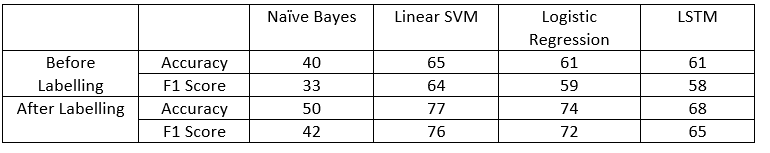

# Grouping of labels

We considered 2 approaches: 

1. Standardising the labels

For this approach, we will only change the labels for consistency.

2. Classifying items broadly

For this approach, we will group similar labels under a more general label.

But before we can conduct any of the aforementioned approaches, we need to first preprocess the data so that it easier when we are checking the dataset later.

## Pre-processing for grouping labels

Steps:
1. Text cleaning of the labels (remove \t and \n in the labels)
2. Retrieve the corresponding UNSPSC codes for convenience.
3. Construct a similarity matrix to suggest similar labels for the current label.

  Steps:
  - Preprocess the labels to create a dictionary, tf-idf model & similarity matrix
  - Lowercase the label and split the label into individual words
  - Create the bag of words for that label
  - Use tf-idf to get the probability of importance for each word
  - Compute the similarity score for every other label against this label
  - Get the top 3 labels with the highest similarity score

4. Lastly, mapping of the old labels to the new labels and unspsc codes.
   
   Main Methodology:
   - Create 3 mapping dictionaries, 1 is for the new labels not found in the original dataset and new UNSPSC codes, ({"New Label" : "New UNSPSC Code"}). 
      
      1 is for the original labels and the original UNSPSC Code in the dataset ({"Old Label": "Old UNSPSC Code"})

      The last one is to indicate what is the new label for this original label. If we have decided to keep it the same, then the new label will be the same as the original label. ({"Old Label": "New Label"})
    
  - Then, we will use the old-new labels dictionary to map old labels to the new labels first. 

  - Then, we will search through the new labels dictionary to find the unspsc code. If it is not there, then it means that this new label is actually a label found in the original dataset so we will go and search through the old labels dictionary instead.

Text Cleaning of labels

In [ ]:
for index, row in overall_df.iterrows():
  label = str(row['Commodity Title'])
  if '\t' in label:
    overall_df.at[index, 'Commodity Title'] = str(row['Commodity Title']).replace('\t', '')
  if '\n' in label:
    overall_df.at[index, 'Commodity Title'] = str(row['Commodity Title']).replace('\n', '')
  overall_df.at[index, 'Commodity Title'] = str(row['Commodity Title']).strip(' ')

Filter all the NaN amongst the labels, if any.

In [ ]:
labels_lst = []
labels_lst.extend(data['Commodity Title (Editted)'].tolist())
labels_lst = list(filter(lambda x: x == x, labels_lst))

Count the frequency of the labels and sort by count

In [ ]:
from collections import Counter, OrderedDict
freq_count=Counter(labels_lst)
freq_count = OrderedDict(sorted(freq_count.items(), key = lambda x:x[1]))

Construct a dictionary where the key is the labels and the value is the corresponding UNSPSC codes. 

In [ ]:
labels_unspsc_dict = {}

for index, row in overall_df.iterrows():
  old_code = row['Normalized UNSPSC']
  new_code = row['Normalized UNSPSC (Editted)']
  old_label = row['Commodity Title']
  new_label = row['Commodity Title (Editted)']
  if new_label not in labels_unspsc_dict:
    labels_unspsc_dict[new_label] = new_code
  if old_label not in labels_unspsc_dict:
    labels_unspsc_dict[old_label] = old_code

Output the row indexes for each label in case we need to refer back to the original excel file.

In [ ]:
labels = []
freqs = []
row_nos = []
codes = []

for label in freq_count:
  labels.append(label)
  count = freq_count[label]
  freqs.append(count)
  rows = data.index[data['Commodity Title (Editted)'] == label].tolist()
  row_nos.append(rows)
  code = round(labels_unspsc_dict[label])
  codes.append(code)

df = pd.DataFrame()
df['Label'] = labels
df['Count'] = freqs
df['Row Indexes'] = row_nos
df['UNSPSC Code'] = codes

df.head()

,Label,Count,Row Indexes,UNSPSC Code
0,Borehole seismic monitoring acquisition services,1,[7],71112328
1,ATM asynchronous transfer mode managed network...,1,[15],83112201
2,Suits,1,[37],53101900
3,Abrasive cartridge rolls,1,[58],31191516
4,Absorption chiller,1,[66],40101713


Construct the similarity matrix

In [ ]:
import nltk
nltk.download('punkt')

import gensim
raw_documents = list(set(labels_lst)) #only work with the original labels

from nltk.tokenize import word_tokenize
gen_docs = [[w.lower() for w in word_tokenize(text)] #lowercase all labels
            for text in raw_documents]

dictionary = gensim.corpora.Dictionary(gen_docs) #create a dictionary 
corpus = [dictionary.doc2bow(gen_doc) for gen_doc in gen_docs] #create a bag of words
tf_idf = gensim.models.TfidfModel(corpus) #tf-idf model
sims = gensim.similarities.Similarity('',tf_idf[corpus],
                                      num_features=len(dictionary)) #similarity matrix


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:718: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Output the top 3 most similar labels with the highest similarity score for each original label

In [ ]:
similar_words = []
for i in df.Label.values:
  #print("Current Label: " + str(i))
  query_doc = [w.lower() for w in word_tokenize(i)] #lowercase each word in the label
  query_doc_bow = dictionary.doc2bow(query_doc) #create a bag of words for each label
  query_doc_tf_idf = tf_idf[query_doc_bow] #use the tf-idf model to get the importance for each word
  #print("Query_doc_tf_idf: " + str(query_doc_tf_idf))
  prob_res = sims[query_doc_tf_idf] #compute similarity score for the other labels
  #print("Similarities: " + str(prob_res)) 
  prob_res = prob_res.argsort()[::-1][:4]
  top_3 = [raw_documents[j] for j in prob_res] #get top 3 for each label
  if i in top_3:
    top_3.remove(i)
  else:
    top_3 = top_3[:-1]
  #print("Top 3: " + str(top_3))
  similar_words.append(top_3)

df['Similar Categories'] = similar_words

Sort by UNSPSC Code so that it easier to see

In [ ]:
df = df.sort_values(by=['UNSPSC Code'])

Output the df into an excel file so that we can start to do our backtesting.

In [ ]:
df.to_excel('Backtesting.xlsx')

Load the labels dictionary earlier into a separate excel sheet so that we can refer to the list of the labels that we have so far

In [ ]:
from openpyxl import load_workbook

book = load_workbook('Backtesting.xlsx')
sheet = book.create_sheet("Labels Masterlist")
for i in labels_unspsc_dict:
  sheet.append([i, labels_unspsc_dict[i]])
#Save the modified excel at desired location    
book.save('Backtesting.xlsx')

Now, we will move on to standardise the labels first.

## Standardising of labels

### Pre-processing of labels

After standardising the labels, we will check on our accuracies and f1 scores again to see if there is a further improvement. A further improvement will imply that we have successfully minimised some human errors.

After setting the correct labels for each label, we need to consolidate the labels first. The excel file now will have 2 new columns, 1 column is called 'New Label' and the other column is 'New Code'. 

We first duplicate the old label and the unspsc code into these 2 columns. Then, if we have decided to change the old label to another label (can also be possibly a new label which is not in the masterlist), then we will update the new code column accordingly. 

In [ ]:
import pandas as pd

labels_df = pd.read_excel('Standardised backtesting.xlsx')

Fill up those cells with empty standardised code. Empty standardised code means that the label is already present.

In [ ]:
labels_ml_df = pd.read_excel('Standardised backtesting.xlsx', sheet_name = 'Labels Masterlist')

labels_dct = dict(zip(labels_ml_df['Label'], labels_ml_df['Code']))

new_labels_dct = {}
classes = set(list(labels_df['New Label'].unique()))
for i in labels_dct: #remove excess unused labels
  if i in classes:
    new_labels_dct[i] = labels_dct[i]

labels_dct = new_labels_dct 

In [ ]:
for index, row in labels_df.iterrows():
  if pd.isna(row['New Code']):
    labels_df.at[index, 'New Code'] = labels_dct[row['New Label']]

Create a dictionary which maps the old labels to new labels. 

Another dictionary will be created, mapping the new label to the new code.

The logic would be as such, we would look through the original dataframe again, but this time, we will add 2 new columns, which is the new label and new code. We will need the first dictionary to get the corresponding new label now and the second dictionary to get the corresponding new code.


In [ ]:
labels_dict = {}
codes_dict = {}

for index, row in labels_df.iterrows():
  old_label = row['Label']
  curr_label = row['New Label']
  curr_code = row['New Code']
  labels_dict[old_label] = curr_label
  codes_dict[curr_label] = curr_code

Now, we will look through the original dataframe and assign each row the new label and new unspsc code.

In [ ]:
new_labels = []
new_codes = []

for index, row in overall_df.iterrows():
  original_label = row['Commodity Title (Editted)']
  new_label = labels_dict[original_label]
  new_code = codes_dict[new_label]
  new_labels.append(new_label)
  new_codes.append(new_code)

overall_df['New Standardised Label'] = new_labels
overall_df['New Standardised Code'] = new_codes

Our pre-processing is done! Now, we can go back to running our baseline models and check the accuracies and f1 scores of the models again.

### Running baseline models

#### Pre-processing

Steps involved here:

    1. Clean the class labels

    2. Removing rows which have empty Item Name and Item Description

    3. Concatenating the Item Name and Item Description Columns so that we do not need to have 2 bags of words later.

    4. Text Cleaning

      - Remove Punctuation
      - Lowercase all the words
      - Tokenize the texts, meaning that each word will become a token
      - Removing stopwords. Stopwords are commonly used words such as 'the', 'she', 'he'.
      - Lemmatizing. Group words to a similar word. For example, 'good', 'better' and 'best' will be changed to 'good'.
      - Stemming. To convert the words to their root form. For example, 'eating' will be changed to 'eat'.
      - Removing special characters, such as '$', '%'
      - Removing numbers
      - Removing line breaks. They will appear as '\r' or '\n' in the text.
      - Removing single character. They are probably just typos.

Step 1: Cleaning of class labels

We noticed that there are some rows with spacing as well as \t and \n in the labels. We need to clean them so that the model will not treat the label with a spacing as a different label.

In [ ]:
for index, row in overall_df.iterrows():
  label = str(row['New Standardised Label'])
  if '\t' in label:
    overall_df.at[index, 'New Standardised Label'] = str(row['New Standardised Label']).replace('\t', '')
  if '\n' in label:
    overall_df.at[index, 'New Standardised Label'] = str(row['New Standardised Label']).replace('\n', '')
  overall_df.at[index, 'New Standardised Label'] = str(row['New Standardised Label']).strip(' ')

The code below describes steps 2 and 3.

In [ ]:
texts = []
classes = []
for index, row in overall_df.iterrows():
  classname = row['New Standardised Label']
  if len(str(row['Item Name'])) == 0 and len(str(row['Item Description'])) == 0: #whole row is empty
    continue
  if pd.isna(row['Item Description']): #keeping only 1 of the columns if the other column is empty
    text = str(row['Item Name'])
  elif pd.isna(row['Item Name']):
    text = str(row['Item Description'])
  else:
    text = str(row['Item Name']) + " " + str(row['Item Description']) #concatenate both text columns to form just 1 column
  if not pd.isna(classname) and not pd.isna(text): #only want rows with non-empty classes and non-empty text
    texts.append(text)
    classes.append(classname)

df = pd.DataFrame()
df['Class'] = classes
df['Text'] = texts

df.head()

Step 4: Text Cleaning

We will write a function so that it is easier to automate the text cleaning later.

In [ ]:
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
nltk.download('wordnet')

def text_cleaning(dataframe):
  new_df = pd.DataFrame()
  texts = []
  classes = []
  tokenizer = RegexpTokenizer(r'\w+')
  stopwords_lst = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()
  stemmer = PorterStemmer()
  for index, row in dataframe.iterrows():
    text = row['Text']
    #remove punctuation
    text = ''.join([i for i in text if i not in string.punctuation])
    #lowercase 
    text = ''.join([i.lower() for i in text])
    #tokenize
    text = ' '.join(tokenizer.tokenize(text))
    #remove stopwords
    text = ' '.join([i for i in text.split() if i not in stopwords_lst])
    #lemmatize
    text = ' '.join([lemmatizer.lemmatize(i) for i in text.split()])
    #stemming
    text = ' '.join([stemmer.stem(i) for i in text.split()])
    #remove special characters
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    #remove numbers
    text = ' '.join([i for i in text.split() if i.isalpha()])
    #remove line breaks
    text = text.replace('\n', " ")
    text = text.replace('\r', " ")
    #remove single character
    text = ' '.join([w for w in text.split() if len(w)>1] )
    classes.append(row['Class'])
    texts.append(text)
  new_df['Class'] = classes
  new_df['Text'] = texts
  return new_df

In [ ]:
cleaned_df = text_cleaning(df)

cleaned_df.head()

Next, we will split the data into train and test so that we can see how well the models perform out of sample. But unlike the conventional train-test-split, we will be using a stratified train test split instead. We have seen from our EDA that there is a huge imbalance of classes so we want to address this problem.

We will first separate those classes with the number of records below the threshold. They will be in the training set but won't appear in the testing set.These rows will be in the excess_df, while the bulk of the data will be in the new_df, as shown below.

The threshold that we will use will be the same as the previous one, which is 20. This is to ensure a fair comparison.

In [ ]:
# record the number of records for each class
unique_classes = cleaned_df['Class'].unique()
unc = {}
for i in unique_classes:
  unc[i] = cleaned_df[cleaned_df['Class'] == i].shape[0]
pd.Series(list(unc.values())).describe()

In [ ]:
# remove the classes with < 20 rows
texts = []
classes = []
excess_texts = []
excess_classes = []
for index, row in cleaned_df.iterrows():
  curr_class = row['Class']
  if unc[curr_class] >= 20:
    texts.append(row['Text'])
    classes.append(curr_class)
  else:
    excess_texts.append(row['Text'])
    excess_classes.append(curr_class)

new_df = pd.DataFrame()
new_df['Class'] = classes
new_df['Text'] = texts
excess_df = pd.DataFrame()
excess_df['Class'] = excess_classes
excess_df['Text'] = excess_texts
print(new_df.shape)
print(excess_df.shape)

In [ ]:
# vectorizing all texts with tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.concat([new_df, excess_df])
tfidf = TfidfVectorizer()
overall_mat = tfidf.fit_transform(df.Text)
overall_y = df.Class

From the overall matrix, we will split it into 2 parts. The excess matrix is for the rows in the excess df, while the main matrix is for the new df.

In [ ]:
excess_classes = set(list(excess_df.Class.unique())) #retrieve the list of classes that are in excess_df
main_idxs = []
excess_idxs = []
idx = 0
for i in overall_y.values: #the idea is to assign the indexes to the corresponding group based on whether the value is in the excess_classes or not.
  if i in excess_classes:
    excess_idxs.append(idx)
  else:
    main_idxs.append(idx)
  idx += 1

main_mat = overall_mat[main_idxs]
main_y = overall_y.values[main_idxs]
excess_mat = overall_mat[excess_idxs]
excess_y = overall_y.values[excess_idxs]
print(main_mat.shape)
print(main_y.shape)
print(excess_mat.shape)
print(excess_y.shape)

Here, we did a stratified split only on the new_df.

In [ ]:
# perform stratified split only on the new_df 
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 0)
for train_index, test_index in split.split(new_df, new_df['Class']):
  strat_train_set = train_index
  strat_test_set = test_index

Splitting the main matrix only into train and test sets. The excess matrix will be fitted into the models directly.

In [ ]:
# convert them into required input shape
corpus_train_mat = main_mat[strat_train_set,]
corpus_test_mat = main_mat[strat_test_set,]
y_train = main_y[strat_train_set]
y_test = main_y[strat_test_set]

print(corpus_train_mat.shape)
print(corpus_test_mat.shape)
print(y_train.shape)
print(y_test.shape)

#### Building the same models

We will use the same models with the same parameters as before to ensure a fair comparison.

Models:

  1. Naive Bayes

  2. Linear SVM

  3. Logistic Regression

  4. LSTM

The steps for each model are the same for the first 3 models, the last model will require some more work because it is a neural network. We will fit the matrix into the model, then predict on the test set and check the evaluation metrics. We will be focusing on the f1 score and accuracy score.

Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nbclassifier = MultinomialNB()
nbclassifier.fit(excess_mat, excess_y)
nbclassifier.fit(corpus_train_mat, y_train)

In [ ]:
#predict class from test data 
predicted = nbclassifier.predict(corpus_test_mat)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: " + str(accuracy_score(y_test, predicted)))
print("Precision: " + str(precision_score(y_test, predicted, average = 'weighted')))
print("Recall: " + str(recall_score(y_test, predicted, average = 'weighted')))
print("F1 Score: " + str(f1_score(y_test, predicted, average = 'weighted')))

Accuracy: 0.509985387238188
Precision: 0.4852563000120781


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.509985387238188
F1 Score: 0.43805572493018247


Linear SVM

In [ ]:
from sklearn.svm import SVC

text_clf = SVC(kernel='linear', probability = True)

In [ ]:
#train model
text_clf.fit(excess_mat, excess_y)
text_clf.fit(corpus_train_mat, y_train)

In [ ]:
#predict class from test data 
predicted = text_clf.predict(corpus_test_mat)

The accuracy is 78, f1 score is 76.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: " + str(accuracy_score(y_test, predicted)))
print("Precision: " + str(precision_score(y_test, predicted, average = 'weighted')))
print("Recall: " + str(recall_score(y_test, predicted, average = 'weighted')))
print("F1 Score: " + str(f1_score(y_test, predicted, average = 'weighted')))

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='sag')
clf.fit(excess_mat, excess_y)
clf.fit(corpus_train_mat, y_train)

In [ ]:
#predict class from test data 
predicted = clf.predict(corpus_test_mat)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: " + str(accuracy_score(y_test, predicted)))
print("Precision: " + str(precision_score(y_test, predicted, average = 'weighted')))
print("Recall: " + str(recall_score(y_test, predicted, average = 'weighted')))
print("F1 Score: " + str(f1_score(y_test, predicted, average = 'weighted')))

Accuracy: 0.7567323081205205
Precision: 0.7561533448810359


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.7567323081205205
F1 Score: 0.7374852066828916


LSTM

This model requires more pre-processing work. We need to set the X sequences to a fixed length so the input matrices will be different from the input matrices used for the earlier models.

In [ ]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential

Prepare the X and Y

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each row.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(cleaned_df['Text'].values)
word_index = tokenizer.word_index #this is important for evaluation of final test dataset

X = tokenizer.texts_to_sequences(cleaned_df['Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

In [ ]:
Y = pd.get_dummies(cleaned_df['Class']).values
print('Shape of label tensor:', Y.shape)

Use the main and excess indexes we have gotten earlier to split X and Y into the main inputs and the excess inputs

In [ ]:
X_main = X[main_idxs]
X_excess = X[excess_idxs]
Y_main = Y[main_idxs]
Y_excess = Y[excess_idxs]
print(X_main.shape)
print(X_excess.shape)
print(Y_main.shape)
print(Y_excess.shape)

Like before, only X_main will be split into train and test set

In [ ]:
corpus_train_mat = X_main[strat_train_set,] #can still use back the same indices from the earlier stratified train test split
corpus_test_mat = X_main[strat_test_set,]
y_train = Y_main[strat_train_set]
y_test = Y_main[strat_test_set]

Build LSTM Model

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(Y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Early stop the training if the validation loss did not improve in 10 epochs. We will also save the current training model if it has a lower validation loss than the previous saved one. 

In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
cp = ModelCheckpoint('careful_lstm_model_threshold_20.hdf5',monitor='val_loss', save_best_only = True)

So for the training, we will first fit the excess data (below threshold) to the model first and let the model train on it for 10 epochs. Then, we will fit it to the bulk of the data with the test set.

In [ ]:
#excess data train for 10 epochs

model.fit(X_excess, Y_excess, epochs = 10, batch_size = 32)

The accuracy is 68%.

In [ ]:
epochs = 50
batch_size = 32

history = model.fit(corpus_train_mat, y_train, epochs=epochs, validation_data=(corpus_test_mat, y_test),
                    batch_size=batch_size,callbacks=[cp, es])

Now, we need to get the F1 score. We can't get the F1 score from model training as the f1 score metric is not supported by keras. Hence, we need to get the model to predict on the test set again and calculate the f1 score from there. First, we need to load the best saved LSTM model.

In [ ]:
from keras.models import load_model

# returns a compiled model identical to the previous one
model = load_model('careful_lstm_model_threshold_20.hdf5')

Get predictions for test set

In [ ]:
predictions = model.predict(corpus_test_mat)

The model will return a list of probabilities for each row where each probability corresponds to the probability of that row belonging to this class. So we will take the class with the highest probability as the predicted class for that row. 

In [ ]:
import numpy as np

predictions_ans = []
for i in predictions:
  predictions_ans.append(np.argmax(i))

Since we encoded the Y by dummy variables earlier, each row will only have a 1 and the rest are 0. The 1 for that column will tell us the correct class for this row.

In [ ]:
correct_ans = []
for i in y_test:
  correct_ans.append(i.tolist().index(1))

Retrieving the F1 Score

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: " + str(accuracy_score(correct_ans, predictions_ans)))
print("Precision: " + str(precision_score(correct_ans, predictions_ans, average = 'weighted')))
print("Recall: " + str(recall_score(correct_ans, predictions_ans, average = 'weighted')))
print("F1 Score: " + str(f1_score(correct_ans, predictions_ans, average = 'weighted')))

Accuracy: 0.6814417924987822
Precision: 0.6532962689899746
Recall: 0.6814417924987822
F1 Score: 0.655075982080433


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As a summary, here are the accuracies and F1 scores we obtained for the models before labelling, after labelling and standardising. There isn't a very significant increase between the standardising and after labelling stages and we wanted to find out why.


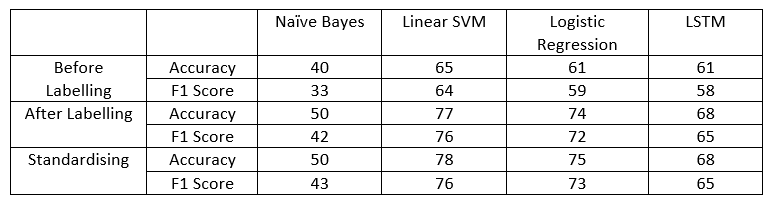

We checked the distribution of the number of records that each class has.

In [ ]:
unique_classes = cleaned_df['Class'].unique()

unc = {}
for i in unique_classes:
  unc[i] = cleaned_df[cleaned_df['Class'] == i].shape[0]

pd.Series(list(unc.values())).describe()

Upon inspection, we found out that at least 25% of the classes still have a count of 1. This means that these classes still do have sufficient sample size and if we were to use this model for forward predictions, the model will definitely not do well for these classes. We thus proposed to group even more labels together so that the classes do not suffer from the problem of low sample size.

## Classifying labels more broadly

So here, we will use the standardised backtesting excel file and create another 2 columns, 'Grouped Label', 'Grouped Code' to indicate the new labels for this stage. We will duplicate the labels and code columns for standardising into these 2 new columns and we will change both columns if there is a need to.

### Pre-processing

In [ ]:
import pandas as pd

labels_df = pd.read_excel('Grouped backtesting.xlsx')

Fill up those cells with empty grouped code. Empty grouped code means that the label is already present.

In [ ]:
labels_ml_df = pd.read_excel('Grouped backtesting.xlsx', sheet_name = 'Labels Masterlist')

labels_dct = dict(zip(labels_ml_df['Label'], labels_ml_df['Code']))

new_labels_dct = {}
classes = set(list(labels_df['New Label'].unique()))
for i in labels_dct: #remove excess unused labels
  if i in classes:
    new_labels_dct[i] = labels_dct[i]

labels_dct = new_labels_dct 

In [ ]:
for index, row in labels_df.iterrows():
  if pd.isna(row['New Grouped Code']):
    labels_df.at[index, 'New Grouped Code'] = labels_dct[row['New Grouped Label']]

Create a dictionary which maps the old labels to new labels. 

Another dictionary will be created, mapping the new label to the new code.

The logic would be as such, we would look through the original dataframe again, but this time, we will add 2 new columns, which is the new label and new code. We will need the first dictionary to get the corresponding new label now and the second dictionary to get the corresponding new code.


In [ ]:
labels_dict = {}
codes_dict = {}

for index, row in labels_df.iterrows():
  old_label = row['Label']
  curr_label = row['Grouped Label']
  curr_code = row['Grouped Code']
  labels_dict[old_label] = curr_label
  codes_dict[curr_label] = curr_code

Now, we will look through the original dataframe and assign each row the new label and new unspsc code.

In [ ]:
new_labels = []
new_codes = []

for index, row in overall_df.iterrows():
  original_label = row['Commodity Title (Editted)']
  new_label = labels_dict[original_label]
  new_code = codes_dict[new_label]
  new_labels.append(new_label)
  new_codes.append(new_code)

overall_df['New Grouped Label'] = new_labels
overall_df['New Grouped Code'] = new_codes

Update overall file

In [ ]:
overall_df.to_excel('Grouping_fiscal_y1.xlsx')

Our pre-processing is done! Now, we can go back to running our baseline models and check the accuracies and f1 scores of the models again.

### Running baseline models

#### Pre-processing

Steps involved here:

    1. Clean the class labels

    2. Removing rows which have empty Item Name and Item Description

    3. Concatenating the Item Name and Item Description Columns so that we do not need to have 2 bags of words later.

    4. Text Cleaning

      - Remove Punctuation
      - Lowercase all the words
      - Tokenize the texts, meaning that each word will become a token
      - Removing stopwords. Stopwords are commonly used words such as 'the', 'she', 'he'.
      - Lemmatizing. Group words to a similar word. For example, 'good', 'better' and 'best' will be changed to 'good'.
      - Stemming. To convert the words to their root form. For example, 'eating' will be changed to 'eat'.
      - Removing special characters, such as '$', '%'
      - Removing numbers
      - Removing line breaks. They will appear as '\r' or '\n' in the text.
      - Removing single character. They are probably just typos.

Step 1: Cleaning of class labels

We noticed that there are some rows with spacing as well as \t and \n in the labels. We need to clean them so that the model will not treat the label with a spacing as a different label.

In [ ]:
for index, row in overall_df.iterrows():
  label = str(row['New Grouped Label'])
  if '\t' in label:
    overall_df.at[index, 'New Grouped Label'] = str(row['New Grouped Label']).replace('\t', '')
  if '\n' in label:
    overall_df.at[index, 'New Grouped Label'] = str(row['New Grouped Label']).replace('\n', '')
  overall_df.at[index, 'New Grouped Label'] = str(row['New Grouped Label']).strip(' ')

The code below describes steps 2 and 3.

In [ ]:
texts = []
classes = []
for index, row in overall_df.iterrows():
  classname = row['New Grouped Label']
  if len(str(row['Item Name'])) == 0 and len(str(row['Item Description'])) == 0: #whole row is empty
    continue
  if pd.isna(row['Item Description']): #keeping only 1 of the columns if the other column is empty
    text = str(row['Item Name'])
  elif pd.isna(row['Item Name']):
    text = str(row['Item Description'])
  else:
    text = str(row['Item Name']) + " " + str(row['Item Description']) #concatenate both text columns to form just 1 column
  if not pd.isna(classname) and not pd.isna(text): #only want rows with non-empty classes and non-empty text
    texts.append(text)
    classes.append(classname)

df = pd.DataFrame()
df['Class'] = classes
df['Text'] = texts

df.head()

Step 4: Text Cleaning

We will write a function so that it is easier to automate the text cleaning later.

In [ ]:
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
nltk.download('wordnet')

def text_cleaning(dataframe):
  new_df = pd.DataFrame()
  texts = []
  classes = []
  tokenizer = RegexpTokenizer(r'\w+')
  stopwords_lst = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()
  stemmer = PorterStemmer()
  for index, row in dataframe.iterrows():
    text = row['Text']
    #remove punctuation
    text = ''.join([i for i in text if i not in string.punctuation])
    #lowercase 
    text = ''.join([i.lower() for i in text])
    #tokenize
    text = ' '.join(tokenizer.tokenize(text))
    #remove stopwords
    text = ' '.join([i for i in text.split() if i not in stopwords_lst])
    #lemmatize
    text = ' '.join([lemmatizer.lemmatize(i) for i in text.split()])
    #stemming
    text = ' '.join([stemmer.stem(i) for i in text.split()])
    #remove special characters
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    #remove numbers
    text = ' '.join([i for i in text.split() if i.isalpha()])
    #remove line breaks
    text = text.replace('\n', " ")
    text = text.replace('\r', " ")
    #remove single character
    text = ' '.join([w for w in text.split() if len(w)>1] )
    classes.append(row['Class'])
    texts.append(text)
  new_df['Class'] = classes
  new_df['Text'] = texts
  return new_df

In [ ]:
cleaned_df = text_cleaning(overall_df)

cleaned_df.head()

Next, we will split the data into train and test so that we can see how well the models perform out of sample. But unlike the conventional train-test-split, we will be using a stratified train test split instead. We have seen from our EDA that there is a huge imbalance of classes so we want to address this problem.

We will first separate those classes with the number of records below the threshold. They will be in the training set but won't appear in the testing set.These rows will be in the excess_df, while the bulk of the data will be in the new_df, as shown below.

The threshold that we will use will be the same as the previous one, which is 20. This is to ensure a fair comparison.

In [ ]:
# record the number of records for each class
unique_classes = cleaned_df['Class'].unique()
unc = {}
for i in unique_classes:
  unc[i] = cleaned_df[cleaned_df['Class'] == i].shape[0]
pd.Series(list(unc.values())).describe()

In [ ]:
# remove the classes with < 20 rows
texts = []
classes = []
excess_texts = []
excess_classes = []
for index, row in cleaned_df.iterrows():
  curr_class = row['Class']
  if unc[curr_class] >= 20:
    texts.append(row['Text'])
    classes.append(curr_class)
  else:
    excess_texts.append(row['Text'])
    excess_classes.append(curr_class)

new_df = pd.DataFrame()
new_df['Class'] = classes
new_df['Text'] = texts
excess_df = pd.DataFrame()
excess_df['Class'] = excess_classes
excess_df['Text'] = excess_texts
print(new_df.shape)
print(excess_df.shape)

In [ ]:
# vectorizing all texts with tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.concat([new_df, excess_df])
tfidf = TfidfVectorizer()
overall_mat = tfidf.fit_transform(df.Text)
overall_y = df.Class

From the overall matrix, we will split it into 2 parts. The excess matrix is for the rows in the excess df, while the main matrix is for the new df.

In [ ]:
excess_classes = set(list(excess_df.Class.unique())) #retrieve the list of classes that are in excess_df
main_idxs = []
excess_idxs = []
idx = 0
for i in overall_y.values: #the idea is to assign the indexes to the corresponding group based on whether the value is in the excess_classes or not.
  if i in excess_classes:
    excess_idxs.append(idx)
  else:
    main_idxs.append(idx)
  idx += 1

main_mat = overall_mat[main_idxs]
main_y = overall_y.values[main_idxs]
excess_mat = overall_mat[excess_idxs]
excess_y = overall_y.values[excess_idxs]
print(main_mat.shape)
print(main_y.shape)
print(excess_mat.shape)
print(excess_y.shape)

Here, we did a stratified split only on the new_df.

In [ ]:
# perform stratified split only on the new_df 
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 0)
for train_index, test_index in split.split(new_df, new_df['Class']):
  strat_train_set = train_index
  strat_test_set = test_index

Splitting the main matrix only into train and test sets. The excess matrix will be fitted into the models directly.

In [ ]:
# convert them into required input shape
corpus_train_mat = main_mat[strat_train_set,]
corpus_test_mat = main_mat[strat_test_set,]
y_train = main_y[strat_train_set]
y_test = main_y[strat_test_set]

print(corpus_train_mat.shape)
print(corpus_test_mat.shape)
print(y_train.shape)
print(y_test.shape)

#### Building the same models

We will use the same models with the same parameters as before to ensure a fair comparison.

Models:

  1. Naive Bayes

  2. Linear SVM

  3. Logistic Regression

  4. LSTM

The steps for each model are the same for the first 3 models, the last model will require some more work because it is a neural network. We will fit the matrix into the model, then predict on the test set and check the evaluation metrics. We will be focusing on the f1 score and accuracy score.

Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nbclassifier = MultinomialNB()
nbclassifier.fit(excess_mat, excess_y)
nbclassifier.fit(corpus_train_mat, y_train)

In [ ]:
#predict class from test data 
predicted = nbclassifier.predict(corpus_test_mat)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: " + str(accuracy_score(y_test, predicted)))
print("Precision: " + str(precision_score(y_test, predicted, average = 'weighted')))
print("Recall: " + str(recall_score(y_test, predicted, average = 'weighted')))
print("F1 Score: " + str(f1_score(y_test, predicted, average = 'weighted')))

Accuracy: 0.5243762729124236
Precision: 0.5139739501486231


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.5243762729124236
F1 Score: 0.45894339405768975


Linear SVM

In [ ]:
from sklearn.svm import SVC

text_clf = SVC(kernel='linear', probability = True)

In [ ]:
#train model
text_clf.fit(excess_mat, excess_y)
text_clf.fit(corpus_train_mat, y_train)

In [ ]:
#predict class from test data 
predicted = text_clf.predict(corpus_test_mat)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: " + str(accuracy_score(y_test, predicted)))
print("Precision: " + str(precision_score(y_test, predicted, average = 'weighted')))
print("Recall: " + str(recall_score(y_test, predicted, average = 'weighted')))
print("F1 Score: " + str(f1_score(y_test, predicted, average = 'weighted')))

Accuracy: 0.7849414460285132
Precision: 0.7954286493824624


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.7849414460285132
F1 Score: 0.7779261585318611


Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='sag')
clf.fit(excess_mat, excess_y)
clf.fit(corpus_train_mat, y_train)

In [ ]:
#predict class from test data 
predicted = clf.predict(corpus_test_mat)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: " + str(accuracy_score(y_test, predicted)))
print("Precision: " + str(precision_score(y_test, predicted, average = 'weighted')))
print("Recall: " + str(recall_score(y_test, predicted, average = 'weighted')))
print("F1 Score: " + str(f1_score(y_test, predicted, average = 'weighted')))

Accuracy: 0.7608197556008147
Precision: 0.7640801200714737


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.7608197556008147
F1 Score: 0.7456666235565022


LSTM

This model requires more pre-processing work. We need to set the X sequences to a fixed length so the input matrices will be different from the input matrices used for the earlier models.

In [ ]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential

Prepare the X and Y

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each row.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(cleaned_df['Text'].values)
word_index = tokenizer.word_index #this is important for evaluation of final test dataset

X = tokenizer.texts_to_sequences(cleaned_df['Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

In [ ]:
Y = pd.get_dummies(cleaned_df['Class']).values
print('Shape of label tensor:', Y.shape)

Use the main and excess indexes we have gotten earlier to split X and Y into the main inputs and the excess inputs

In [ ]:
X_main = X[main_idxs]
X_excess = X[excess_idxs]
Y_main = Y[main_idxs]
Y_excess = Y[excess_idxs]
print(X_main.shape)
print(X_excess.shape)
print(Y_main.shape)
print(Y_excess.shape)

Like before, only X_main will be split into train and test set

In [ ]:
corpus_train_mat = X_main[strat_train_set,] #can still use back the same indices from the earlier stratified train test split
corpus_test_mat = X_main[strat_test_set,]
y_train = Y_main[strat_train_set]
y_test = Y_main[strat_test_set]

Build LSTM Model

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(Y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Early stop the training if the validation loss did not improve in 10 epochs. We will also save the current training model if it has a lower validation loss than the previous saved one. 

In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
cp = ModelCheckpoint('reckless_lstm_model_threshold_20.hdf5',monitor='val_loss', save_best_only = True)

So for the training, we will first fit the excess data (below threshold) to the model first and let the model train on it for 10 epochs. Then, we will fit it to the bulk of the data with the test set.

In [ ]:
#excess data train for 10 epochs

model.fit(X_excess, Y_excess, epochs = 10, batch_size = 32)

The accuracy is 70%.

In [ ]:
epochs = 50
batch_size = 32

history = model.fit(corpus_train_mat, y_train, epochs=epochs, validation_data=(corpus_test_mat, y_test),
                    batch_size=batch_size,callbacks=[cp, es])

Now, we need to get the F1 score. We can't get the F1 score from model training as the f1 score metric is not supported by keras. Hence, we need to get the model to predict on the test set again and calculate the f1 score from there. First, we need to load the best saved LSTM model.

In [ ]:
from keras.models import load_model

# returns a compiled model identical to the previous one
model = load_model('reckless_lstm_model_threshold_20.hdf5')

Get predictions for test set

In [ ]:
predictions = model.predict(corpus_test_mat)

The model will return a list of probabilities for each row where each probability corresponds to the probability of that row belonging to this class. So we will take the class with the highest probability as the predicted class for that row. 

In [ ]:
import numpy as np

predictions_ans = []
for i in predictions:
  predictions_ans.append(np.argmax(i))

Since we encoded the Y by dummy variables earlier, each row will only have a 1 and the rest are 0. The 1 for that column will tell us the correct class for this row.

In [ ]:
correct_ans = []
for i in y_test:
  correct_ans.append(i.tolist().index(1))

Retrieving the F1 Score

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: " + str(accuracy_score(correct_ans, predictions_ans)))
print("Precision: " + str(precision_score(correct_ans, predictions_ans, average = 'weighted')))
print("Recall: " + str(recall_score(correct_ans, predictions_ans, average = 'weighted')))
print("F1 Score: " + str(f1_score(correct_ans, predictions_ans, average = 'weighted')))

Accuracy: 0.7050025458248472
Precision: 0.68857763174546
Recall: 0.7050025458248472
F1 Score: 0.6854898506803456


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As a summary, here are the accuracies and F1 scores we obtained all 4 stages:
1. Before Labelling
2. After Labelling
3. Standardising
4. Classifying broadly

We can see that the last stage is the best and the accuracies and f1 scores improved over the 4 stages, as expected. As such, we have decided to use the labels obtained at the last stage as the final labels. Additionally, because of the huge amount of time needed to get the predicted probabilities for the sklearn models, we have decided to use the LSTM model for our forward prediction later.

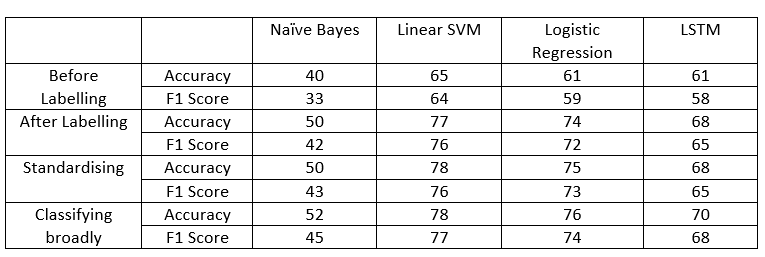

Now, we will use the LSTM model from the last stage and predict on the y1 data again. But this time, we will retrieve the top 2 predicted classes as well as the corresponding probabilities. We will then check those rows with the difference below a certain threshold (to be determined). 

# Backtesting on y1 data

Here, we will use the saved model from grouping earlier to predict on the year 1 data. We will retrieve the top 2 predicted classes with the respective probabilities. We will calculate the difference between the 2 probabilities and investigate those rows with a difference below a certain threshold.

This is to minimise any human errors made while labelling the data.

Load model from stage 4

In [ ]:
from keras.models import load_model

# returns a compiled model identical to the previous one
model = load_model('reckless_lstm_model_threshold_20.hdf5')

Fit the model to predict on entire dataset

In [ ]:
predictions = model.predict(X)

Retrieving the classes

In [ ]:
labels = list(pd.get_dummies(cleaned_df['Class']).columns)

Retrieving the top 2 classes as well as the corresponding probabilities

In [ ]:
import numpy as np

top_classes = []
second_classes = []
top_probs = []
second_probs = []
differences = []
classes = []
correct_or_wrong = []

for index, row in cleaned_df.iterrows():
  probs = probabilities[index]
  top_2 = np.argsort(probs)[-2:][::-1]
  top_2_labels = [labels[i] for i in top_2]
  top_classes.append(top_2_labels[0])
  second_classes.append(top_2_labels[1])
  difference = probs[top_2[0]] - probs[top_2[1]]
  top_probs.append(probs[top_2[0]])
  second_probs.append(probs[top_2[1]])
  differences.append(difference)
  classes.append(row['Class'])
  if top_2_labels[0] == row['Class']:
    ans = 'Correct'
  else:
    ans = 'Wrong'
  correct_or_wrong.append(ans)


overall_df['Correct Class'] = classes
overall_df['1st Predicted Class'] = top_classes
overall_df['1st Predicted Probability'] = top_probs
overall_df['2nd Predicted Class'] = second_classes
overall_df['2nd Predicted Probability'] = second_probs
overall_df['Difference'] = differences
overall_df['Correct or Wrong'] = correct_or_wrong
overall_df.head()

Get the distribution of the differences to decide on threshold. 

In [ ]:
overall_df['Difference'].describe()

count    90396.000000
mean         0.694849
std          0.338489
min          0.000005
25%          0.427476
50%          0.864508
75%          0.977951
max          0.999899
Name: Difference, dtype: float64

Output into excel file

In [ ]:
overall_df.to_excel('Backtesting.xlsx')

Retrieve the labels we have so far and add into a separate sheet

In [ ]:
labels = dict(zip(overall_df['New Grouped Label'], overall_df['New Grouped Code']))

In [ ]:
from openpyxl import load_workbook

book = load_workbook('Backtesting.xlsx')
sheet = book.create_sheet("Labels Masterlist")
#Load dataframe into new sheet
for i in labels:
  sheet.append([i, labels[i]])
#Save the modified excel at desired location    
book.save('Backtesting.xlsx')

Now that we have performed backtesting on the y1 data, we will retrain the LSTM model and this will be the model that we will use for forward predictions.

# Retrain LSTM model on y1 data

We will again check the performance of the model. After that, we will fit the validation set to the model.

In [ ]:
import pandas as pd

overall_df = pd.read_excel("Backtesting.xlsx")

Fill up those cells with empty backtest code. Empty backtest code means that the label is already present.

In [ ]:
labels_df = pd.read_excel('Backtesting.xlsx', sheet_name = 'Labels Masterlist')

labels_dct = dict(zip(labels_df['Label'], labels_df['Code']))

In [ ]:
for index, row in overall_df.iterrows():
  if pd.isna(row['Backtest Code']):
    overall_df.at[index, 'Backtest Code'] = labels_dct[row['Backtest Label']]

## Pre-processing

Steps involved here:

    1. Clean the class labels

    2. Removing rows which have empty Item Name and Item Description

    3. Concatenating the Item Name and Item Description Columns so that we do not need to have 2 bags of words later.

    4. Text Cleaning

      - Remove Punctuation
      - Lowercase all the words
      - Tokenize the texts, meaning that each word will become a token
      - Removing stopwords. Stopwords are commonly used words such as 'the', 'she', 'he'.
      - Lemmatizing. Group words to a similar word. For example, 'good', 'better' and 'best' will be changed to 'good'.
      - Stemming. To convert the words to their root form. For example, 'eating' will be changed to 'eat'.
      - Removing special characters, such as '$', '%'
      - Removing numbers
      - Removing line breaks. They will appear as '\r' or '\n' in the text.
      - Removing single character. They are probably just typos.

Step 1: Cleaning of class labels

We noticed that there are some rows with spacing as well as \t and \n in the labels. We need to clean them so that the model will not treat the label with a spacing as a different label.

In [ ]:
for index, row in overall_df.iterrows():
  label = str(row['Backtest Label'])
  if '\t' in label:
    overall_df.at[index, 'Backtest Label'] = str(row['Backtest Label']).replace('\t', '')
  if '\n' in label:
    overall_df.at[index, 'Backtest Label'] = str(row['Backtest Label']).replace('\n', '')
  overall_df.at[index, 'Backtest Label'] = str(row['Backtest Label']).strip(' ')

The code below describes steps 2 and 3.

In [ ]:
texts = []
classes = []
for index, row in overall_df.iterrows():
  classname = row['Backtest Label']
  if len(str(row['Item Name'])) == 0 and len(str(row['Item Description'])) == 0: #whole row is empty
    continue
  if pd.isna(row['Item Description']): #keeping only 1 of the columns if the other column is empty
    text = str(row['Item Name'])
  elif pd.isna(row['Item Name']):
    text = str(row['Item Description'])
  else:
    text = str(row['Item Name']) + " " + str(row['Item Description']) #concatenate both text columns to form just 1 column
  if not pd.isna(classname) and not pd.isna(text): #only want rows with non-empty classes and non-empty text
    texts.append(text)
    classes.append(classname)

df = pd.DataFrame()
df['Class'] = classes
df['Text'] = texts

df.head()

Step 4: Text Cleaning

We will write a function so that it is easier to automate the text cleaning later.

In [ ]:
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
nltk.download('wordnet')

def text_cleaning(dataframe):
  new_df = pd.DataFrame()
  texts = []
  classes = []
  tokenizer = RegexpTokenizer(r'\w+')
  stopwords_lst = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()
  stemmer = PorterStemmer()
  for index, row in dataframe.iterrows():
    text = row['Text']
    #remove punctuation
    text = ''.join([i for i in text if i not in string.punctuation])
    #lowercase 
    text = ''.join([i.lower() for i in text])
    #tokenize
    text = ' '.join(tokenizer.tokenize(text))
    #remove stopwords
    text = ' '.join([i for i in text.split() if i not in stopwords_lst])
    #lemmatize
    text = ' '.join([lemmatizer.lemmatize(i) for i in text.split()])
    #stemming
    text = ' '.join([stemmer.stem(i) for i in text.split()])
    #remove special characters
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    #remove numbers
    text = ' '.join([i for i in text.split() if i.isalpha()])
    #remove line breaks
    text = text.replace('\n', " ")
    text = text.replace('\r', " ")
    #remove single character
    text = ' '.join([w for w in text.split() if len(w)>1] )
    classes.append(row['Class'])
    texts.append(text)
  new_df['Class'] = classes
  new_df['Text'] = texts
  return new_df

In [ ]:
cleaned_df = text_cleaning(df)

cleaned_df.head()

Next, we will split the data into train and test so that we can see how well the models perform out of sample. But unlike the conventional train-test-split, we will be using a stratified train test split instead. We have seen from our EDA that there is a huge imbalance of classes so we want to address this problem.

We will first separate those classes with the number of records below the threshold. They will be in the training set but won't appear in the testing set.These rows will be in the excess_df, while the bulk of the data will be in the new_df, as shown below.

The threshold that we will use will be the same as the previous one, which is 20. This is to ensure a fair comparison.

In [ ]:
# record the number of records for each class
unique_classes = cleaned_df['Class'].unique()
unc = {}
for i in unique_classes:
  unc[i] = cleaned_df[cleaned_df['Class'] == i].shape[0]
pd.Series(list(unc.values())).describe()

In [ ]:
# remove the classes with < 20 rows
texts = []
classes = []
excess_texts = []
excess_classes = []
for index, row in cleaned_df.iterrows():
  curr_class = row['Class']
  if unc[curr_class] >= 20:
    texts.append(row['Text'])
    classes.append(curr_class)
  else:
    excess_texts.append(row['Text'])
    excess_classes.append(curr_class)

new_df = pd.DataFrame()
new_df['Class'] = classes
new_df['Text'] = texts
excess_df = pd.DataFrame()
excess_df['Class'] = excess_classes
excess_df['Text'] = excess_texts
print(new_df.shape)
print(excess_df.shape)

In [ ]:
# vectorizing all texts with tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.concat([new_df, excess_df])
tfidf = TfidfVectorizer()
overall_mat = tfidf.fit_transform(df.Text)
overall_y = df.Class

From the overall matrix, we will split it into 2 parts. The excess matrix is for the rows in the excess df, while the main matrix is for the new df.

In [ ]:
excess_classes = set(list(excess_df.Class.unique())) #retrieve the list of classes that are in excess_df
main_idxs = []
excess_idxs = []
idx = 0
for i in overall_y.values: #the idea is to assign the indexes to the corresponding group based on whether the value is in the excess_classes or not.
  if i in excess_classes:
    excess_idxs.append(idx)
  else:
    main_idxs.append(idx)
  idx += 1

main_mat = overall_mat[main_idxs]
main_y = overall_y.values[main_idxs]
excess_mat = overall_mat[excess_idxs]
excess_y = overall_y.values[excess_idxs]
print(main_mat.shape)
print(main_y.shape)
print(excess_mat.shape)
print(excess_y.shape)

Here, we did a stratified split only on the new_df.

In [ ]:
# perform stratified split only on the new_df 
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 0)
for train_index, test_index in split.split(new_df, new_df['Class']):
  strat_train_set = train_index
  strat_test_set = test_index

Splitting the main matrix only into train and test sets. The excess matrix will be fitted into the models directly.

In [ ]:
# convert them into required input shape
corpus_train_mat = main_mat[strat_train_set,]
corpus_test_mat = main_mat[strat_test_set,]
y_train = main_y[strat_train_set]
y_test = main_y[strat_test_set]

print(corpus_train_mat.shape)
print(corpus_test_mat.shape)
print(y_train.shape)
print(y_test.shape)

## Training LSTM model

In [ ]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential

Prepare the X and Y

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each row.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(cleaned_df['Text'].values)
word_index = tokenizer.word_index #this is important for evaluation of final test dataset

X = tokenizer.texts_to_sequences(cleaned_df['Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

In [ ]:
Y = pd.get_dummies(cleaned_df['Class']).values
print('Shape of label tensor:', Y.shape)

Use the main and excess indexes we have gotten earlier to split X and Y into the main inputs and the excess inputs

In [ ]:
X_main = X[main_idxs]
X_excess = X[excess_idxs]
Y_main = Y[main_idxs]
Y_excess = Y[excess_idxs]
print(X_main.shape)
print(X_excess.shape)
print(Y_main.shape)
print(Y_excess.shape)

Like before, only X_main will be split into train and test set

In [ ]:
corpus_train_mat = X_main[strat_train_set,] #can still use back the same indices from the earlier stratified train test split
corpus_test_mat = X_main[strat_test_set,]
y_train = Y_main[strat_train_set]
y_test = Y_main[strat_test_set]

Build LSTM Model

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(Y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Early stop the training if the validation loss did not improve in 10 epochs. We will also save the current training model if it has a lower validation loss than the previous saved one. 

In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
cp = ModelCheckpoint('backtesting_lstm_model_threshold_20.hdf5',monitor='val_loss', save_best_only = True)

So for the training, we will first fit the excess data (below threshold) to the model first and let the model train on it for 10 epochs. Then, we will fit it to the bulk of the data with the test set.

In [ ]:
#excess data train for 10 epochs

model.fit(X_excess, Y_excess, epochs = 10, batch_size = 32)

The accuracy is 71%.

In [ ]:
epochs = 50
batch_size = 32

history = model.fit(corpus_train_mat, y_train, epochs=epochs, validation_data=(corpus_test_mat, y_test),
                    batch_size=batch_size,callbacks=[cp, es])

Now, we need to get the F1 score. We can't get the F1 score from model training as the f1 score metric is not supported by keras. Hence, we need to get the model to predict on the test set again and calculate the f1 score from there. First, we need to load the best saved LSTM model.

In [ ]:
from keras.models import load_model

# returns a compiled model identical to the previous one
model = load_model('backtesting_lstm_model_threshold_20.hdf5')

Get predictions for test set

In [ ]:
predictions = model.predict(corpus_test_mat)

The model will return a list of probabilities for each row where each probability corresponds to the probability of that row belonging to this class. So we will take the class with the highest probability as the predicted class for that row. 

In [ ]:
import numpy as np

predictions_ans = []
for i in predictions:
  predictions_ans.append(np.argmax(i))

Since we encoded the Y by dummy variables earlier, each row will only have a 1 and the rest are 0. The 1 for that column will tell us the correct class for this row.

In [ ]:
correct_ans = []
for i in y_test:
  correct_ans.append(i.tolist().index(1))

Retrieving the F1 Score

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: " + str(accuracy_score(correct_ans, predictions_ans)))
print("Precision: " + str(precision_score(correct_ans, predictions_ans, average = 'weighted')))
print("Recall: " + str(recall_score(correct_ans, predictions_ans, average = 'weighted')))
print("F1 Score: " + str(f1_score(correct_ans, predictions_ans, average = 'weighted')))

Accuracy: 0.7148308318494022
Precision: 0.7022206593279389
Recall: 0.7148308318494022
F1 Score: 0.6982653370329008


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Now, we will fit the model to the validation set so as to prepare it for forward predictions. We will train it for 10 epochs.

In [ ]:
model.fit(corpus_test_mat, y_test, epochs = 10, batch_size = 32)

Save model

In [ ]:
model.save('backtesting_lstm_model_threshold_20.hdf5')

Save tokenizer and labels for future predictions

In [ ]:
labels = dict(zip(overall_df['Backtest Label'], overall_df['Backtest Code']))

In [ ]:
labels = pd.DataFrame.from_dict(labels)
labels.to_excel('Labels Masterlist.xlsx')

In [ ]:
import pickle

with open('backtesting_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)

#with open('final_tokenizer.pickle', 'rb') as handle:
    #tokenizer = pickle.load(handle)

with open('labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle)

As a summary, here are the accuracies and F1 scores we obtained so far:

1. Before Labelling
2. After Labelling
3. Standardising
4. Classifying broadly
5. Backtesting on y1 data

As mentioned earlier, due to the long computational time to get the predicted probabilities for the sklearn models, we will be focusing on LSTM only from now onwards.

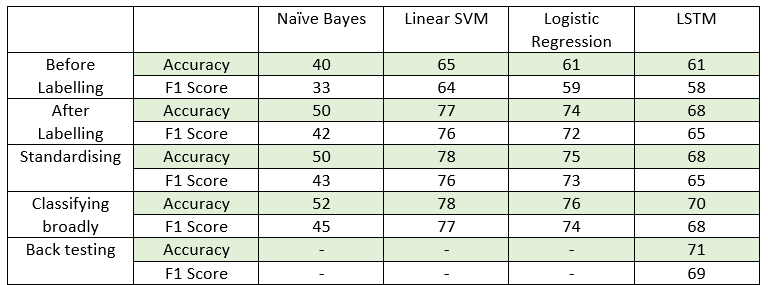

Now, we will proceed to forward predictions where we will conduct 3 snowball cycles, each will be a month of data.

# Forward Predictions Cycle 1

For each cycle, we will use the model from the previous stage to forward predict the labels.

Then we will only look at rows with the difference below a certain threshold as the data is unseen. Inevitably, we might need to add new labels. 

With the modified labels, we will retrain the model.

We will use this model to backtest on the training set.

The threshold for this might not be similar to the threshold above. This is to ensure that the new labels are predicted correctly by the model.

Then, we will retrain the model with the updated labels.

For each cycle, we will be doing on 1 month of data.

In [ ]:
import pandas as pd

overall_df = pd.read_excel('Forward Predict Cycle 1.xlsx')

## Backtesting Part 1

### Pre-processing

Steps involved here:

    1. Clean the class labels

    2. Removing rows which have empty Item Name and Item Description

    3. Concatenating the Item Name and Item Description Columns so that we do not need to have 2 bags of words later.

    4. Text Cleaning

      - Remove Punctuation
      - Lowercase all the words
      - Tokenize the texts, meaning that each word will become a token
      - Removing stopwords. Stopwords are commonly used words such as 'the', 'she', 'he'.
      - Lemmatizing. Group words to a similar word. For example, 'good', 'better' and 'best' will be changed to 'good'.
      - Stemming. To convert the words to their root form. For example, 'eating' will be changed to 'eat'.
      - Removing special characters, such as '$', '%'
      - Removing numbers
      - Removing line breaks. They will appear as '\r' or '\n' in the text.
      - Removing single character. They are probably just typos.


Step 1: Cleaning of class labels

We noticed that there are some rows with spacing as well as \t and \n in the labels. We need to clean them so that the model will not treat the label with a spacing as a different label.

In [ ]:
for index, row in overall_df.iterrows():
  label = str(row['Original Label'])
  if '\t' in label:
    overall_df.at[index, 'Original Label'] = str(row['Original Label']).replace('\t', '')
  if '\n' in label:
    overall_df.at[index, 'Original Label'] = str(row['Original Label']).replace('\n', '')
  overall_df.at[index, 'Original Label'] = str(row['Original Label']).strip(' ')

The code below describes steps 2 and 3.

In [ ]:
texts = []
classes = []
for index, row in overall_df.iterrows():
  classname = row['Original Label']
  if len(str(row['Item Name'])) == 0 and len(str(row['Item Description'])) == 0: #whole row is empty
    continue
  if pd.isna(row['Item Description']): #keeping only 1 of the columns if the other column is empty
    text = str(row['Item Name'])
  elif pd.isna(row['Item Name']):
    text = str(row['Item Description'])
  else:
    text = str(row['Item Name']) + " " + str(row['Item Description']) #concatenate both text columns to form just 1 column
  if not pd.isna(classname) and not pd.isna(text): #only want rows with non-empty classes and non-empty text
    texts.append(text)
    classes.append(classname)

df = pd.DataFrame()
df['Class'] = classes
df['Text'] = texts

df.head()

Step 4: Text Cleaning

We will write a function so that it is easier to automate the text cleaning later.

In [ ]:
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
nltk.download('wordnet')

def text_cleaning(dataframe):
  new_df = pd.DataFrame()
  texts = []
  classes = []
  tokenizer = RegexpTokenizer(r'\w+')
  stopwords_lst = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()
  stemmer = PorterStemmer()
  for index, row in dataframe.iterrows():
    text = row['Text']
    #remove punctuation
    text = ''.join([i for i in text if i not in string.punctuation])
    #lowercase 
    text = ''.join([i.lower() for i in text])
    #tokenize
    text = ' '.join(tokenizer.tokenize(text))
    #remove stopwords
    text = ' '.join([i for i in text.split() if i not in stopwords_lst])
    #lemmatize
    text = ' '.join([lemmatizer.lemmatize(i) for i in text.split()])
    #stemming
    text = ' '.join([stemmer.stem(i) for i in text.split()])
    #remove special characters
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    #remove numbers
    text = ' '.join([i for i in text.split() if i.isalpha()])
    #remove line breaks
    text = text.replace('\n', " ")
    text = text.replace('\r', " ")
    #remove single character
    text = ' '.join([w for w in text.split() if len(w)>1] )
    classes.append(row['Class'])
    texts.append(text)
  new_df['Class'] = classes
  new_df['Text'] = texts
  return new_df

In [ ]:
cleaned_df = text_cleaning(df)

cleaned_df.head()

Load saved tokenizer and saved labels

In [ ]:
import pickle

#with open('backtesting_tokenizer.pickle', 'wb') as handle:
    #pickle.dump(tokenizer, handle)

with open('backtesting_tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

#with open('labels.pickle', 'wb') as handle:
    #pickle.dump(tokenizer, handle)

with open('labels.pickle', 'rb') as handle:
    labels = pickle.load(handle)

Use tokenizer to convert the texts to sequences

In [ ]:
tokenizer.fit_on_texts(cleaned_df['Text'].values)

X = tokenizer.texts_to_sequences(cleaned_df['Text'].values)
X = pad_sequences(X, maxlen=250)

In [ ]:
Y = list(labels.keys())

### Load LSTM model to make predictions

In [ ]:
from keras.models import load_model

# returns a compiled model identical to the previous one
model = load_model('backtesting_lstm_model_threshold_20.hdf5')

Get predictions

In [ ]:
predictions = model.predict(X)

Retrieving the top 2 classes as well as the corresponding probabilities

We won't be matching the original labels to the predicted labels since the style of labelling is different. Rather, we will just be checking on the difference in probabilities between the top 2 predicted classes and decide which rows to look at.

In [ ]:
import numpy as np

top_classes = []
second_classes = []
top_probs = []
second_probs = []
differences = []
classes = []


for index, row in cleaned_df.iterrows():
  probs = probabilities[index]
  top_2 = np.argsort(probs)[-2:][::-1]
  top_2_labels = [labels[i] for i in top_2]
  top_classes.append(top_2_labels[0])
  second_classes.append(top_2_labels[1])
  difference = probs[top_2[0]] - probs[top_2[1]]
  top_probs.append(probs[top_2[0]])
  second_probs.append(probs[top_2[1]])
  differences.append(difference)
  classes.append(row['Class'])


overall_df['Original Class'] = classes
overall_df['1st Predicted Class'] = top_classes
overall_df['1st Predicted Probability'] = top_probs
overall_df['2nd Predicted Class'] = second_classes
overall_df['2nd Predicted Probability'] = second_probs
overall_df['Difference'] = differences
overall_df.head()

Get the statistical distribution of the differences. Then, we will decide on the threshold. 

In [ ]:
overall_df['Difference'].describe()

Save dataframe into an excel file

In [ ]:
overall_df.to_excel('Forward Predictions Cycle 1 Part 1.xlsx')

Then, we will now proceed to manual checking the labels. Then, we will retrain the LSTM model on y1 + 1 month of data. We have merged the fiscal y1 data with this month of data into the same excel file to make it more convenient.

## Retrain LSTM model

We will fit the entire dataset (y1 + 1 month) into the model to retrain it.

In [ ]:
overall_df = pd.read_excel('Forward Predictions Cycle 1 Part 1.xlsx')

labels_df = pd.read_excel('Forward Predictions Cycle 1 Part 1.xlsx', sheet_name = 'Labels Masterlist')
labels_dct = dict(zip(labels_df['Label'], labels_df['Code']))

### Pre-processing

Steps involved here:

    1. Clean the class labels

    2. Removing rows which have empty Item Name and Item Description

    3. Concatenating the Item Name and Item Description Columns so that we do not need to have 2 bags of words later.

    4. Text Cleaning

      - Remove Punctuation
      - Lowercase all the words
      - Tokenize the texts, meaning that each word will become a token
      - Removing stopwords. Stopwords are commonly used words such as 'the', 'she', 'he'.
      - Lemmatizing. Group words to a similar word. For example, 'good', 'better' and 'best' will be changed to 'good'.
      - Stemming. To convert the words to their root form. For example, 'eating' will be changed to 'eat'.
      - Removing special characters, such as '$', '%'
      - Removing numbers
      - Removing line breaks. They will appear as '\r' or '\n' in the text.
      - Removing single character. They are probably just typos.


Step 1: Cleaning of class labels

We noticed that there are some rows with spacing as well as \t and \n in the labels. We need to clean them so that the model will not treat the label with a spacing as a different label.

In [ ]:
for index, row in overall_df.iterrows():
  label = str(row['New Label'])
  if '\t' in label:
    overall_df.at[index, 'New Label'] = str(row['New Label']).replace('\t', '')
  if '\n' in label:
    overall_df.at[index, 'New Label'] = str(row['New Label']).replace('\n', '')
  overall_df.at[index, 'New Label'] = str(row['New Label']).strip(' ')

The code below describes steps 2 and 3.

In [ ]:
texts = []
classes = []
for index, row in overall_df.iterrows():
  classname = row['New Label']
  if len(str(row['Item Name'])) == 0 and len(str(row['Item Description'])) == 0: #whole row is empty
    continue
  if pd.isna(row['Item Description']): #keeping only 1 of the columns if the other column is empty
    text = str(row['Item Name'])
  elif pd.isna(row['Item Name']):
    text = str(row['Item Description'])
  else:
    text = str(row['Item Name']) + " " + str(row['Item Description']) #concatenate both text columns to form just 1 column
  if not pd.isna(classname) and not pd.isna(text): #only want rows with non-empty classes and non-empty text
    texts.append(text)
    classes.append(classname)

df = pd.DataFrame()
df['Class'] = classes
df['Text'] = texts

df.head()

Step 4: Text Cleaning

We will write a function so that it is easier to automate the text cleaning later.

In [ ]:
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
nltk.download('wordnet')

def text_cleaning(dataframe):
  new_df = pd.DataFrame()
  texts = []
  classes = []
  tokenizer = RegexpTokenizer(r'\w+')
  stopwords_lst = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()
  stemmer = PorterStemmer()
  for index, row in dataframe.iterrows():
    text = row['Text']
    #remove punctuation
    text = ''.join([i for i in text if i not in string.punctuation])
    #lowercase 
    text = ''.join([i.lower() for i in text])
    #tokenize
    text = ' '.join(tokenizer.tokenize(text))
    #remove stopwords
    text = ' '.join([i for i in text.split() if i not in stopwords_lst])
    #lemmatize
    text = ' '.join([lemmatizer.lemmatize(i) for i in text.split()])
    #stemming
    text = ' '.join([stemmer.stem(i) for i in text.split()])
    #remove special characters
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    #remove numbers
    text = ' '.join([i for i in text.split() if i.isalpha()])
    #remove line breaks
    text = text.replace('\n', " ")
    text = text.replace('\r', " ")
    #remove single character
    text = ' '.join([w for w in text.split() if len(w)>1] )
    classes.append(row['Class'])
    texts.append(text)
  new_df['Class'] = classes
  new_df['Text'] = texts
  return new_df

In [ ]:
cleaned_df = text_cleaning(df)

cleaned_df.head()

### Training LSTM model

In [ ]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential

Prepare the X and Y

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each row.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(cleaned_df['Text'].values)
word_index = tokenizer.word_index #this is important for evaluation of final test dataset

X = tokenizer.texts_to_sequences(cleaned_df['Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

In [ ]:
Y = pd.get_dummies(cleaned_df['Class']).values
print('Shape of label tensor:', Y.shape)

Use the main and excess indexes we have gotten earlier to split X and Y into the main inputs and the excess inputs

In [ ]:
X_main = X[main_idxs]
X_excess = X[excess_idxs]
Y_main = Y[main_idxs]
Y_excess = Y[excess_idxs]
print(X_main.shape)
print(X_excess.shape)
print(Y_main.shape)
print(Y_excess.shape)

Like before, only X_main will be split into train and test set

In [ ]:
corpus_train_mat = X_main[strat_train_set,] #can still use back the same indices from the earlier stratified train test split
corpus_test_mat = X_main[strat_test_set,]
y_train = Y_main[strat_train_set]
y_test = Y_main[strat_test_set]

Build LSTM Model

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(Y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Early stop the training if the validation loss did not improve in 10 epochs. We will also save the current training model if it has a lower validation loss than the previous saved one. 

In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
cp = ModelCheckpoint('fp_cycle1_lstm_model_threshold_20.hdf5',monitor='val_loss', save_best_only = True)

So for the training, we will first fit the excess data (below threshold) to the model first and let the model train on it for 10 epochs. Then, we will fit it to the bulk of the data with the test set.
At the end, we will fit the validation set to the model as well.

In [ ]:
#excess data train for 10 epochs

model.fit(X_excess, Y_excess, epochs = 10, batch_size = 32)

In [ ]:
epochs = 50
batch_size = 32

history = model.fit(corpus_train_mat, y_train, epochs=epochs, validation_data=(corpus_test_mat, y_test),
                    batch_size=batch_size,callbacks=[cp, es])

In [ ]:
from keras.models import load_model

# returns a compiled model identical to the previous one
model = load_model('fp_cycle1_lstm_model_threshold_20.hdf5')

In [ ]:
model.fit(corpus_test_mat, y_test, epochs = 10, batch_size = 32)

Save model

In [ ]:
model.save('fp_cycle1_lstm_model_threshold_20.hdf5')

Save tokenizer and labels

In [ ]:
import pickle

with open('fp_cycle1_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)

#with open('fp_cycle1_tokenizer.pickle', 'rb') as handle:
    #tokenizer = pickle.load(handle)

with open('fp_cycle1_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle)

#with open('fp_cycle1_labels.pickle', 'rb') as handle:
    #labels = pickle.load(handle)

## Backtesting Part 2

In [ ]:
overall_df = pd.read_excel('FP_cycle1.xlsx')

### Pre-processing

Steps involved here:

    1. Clean the class labels

    2. Removing rows which have empty Item Name and Item Description

    3. Concatenating the Item Name and Item Description Columns so that we do not need to have 2 bags of words later.

    4. Text Cleaning

      - Remove Punctuation
      - Lowercase all the words
      - Tokenize the texts, meaning that each word will become a token
      - Removing stopwords. Stopwords are commonly used words such as 'the', 'she', 'he'.
      - Lemmatizing. Group words to a similar word. For example, 'good', 'better' and 'best' will be changed to 'good'.
      - Stemming. To convert the words to their root form. For example, 'eating' will be changed to 'eat'.
      - Removing special characters, such as '$', '%'
      - Removing numbers
      - Removing line breaks. They will appear as '\r' or '\n' in the text.
      - Removing single character. They are probably just typos.


Step 1: Cleaning of class labels

We noticed that there are some rows with spacing as well as \t and \n in the labels. We need to clean them so that the model will not treat the label with a spacing as a different label.

In [ ]:
for index, row in overall_df.iterrows():
  label = str(row['New Label'])
  if '\t' in label:
    overall_df.at[index, 'New Label'] = str(row['New Label']).replace('\t', '')
  if '\n' in label:
    overall_df.at[index, 'New Label'] = str(row['New Label']).replace('\n', '')
  overall_df.at[index, 'New Label'] = str(row['New Label']).strip(' ')

The code below describes steps 2 and 3.

In [ ]:
texts = []
classes = []
for index, row in overall_df.iterrows():
  classname = row['New Label']
  if len(str(row['Item Name'])) == 0 and len(str(row['Item Description'])) == 0: #whole row is empty
    continue
  if pd.isna(row['Item Description']): #keeping only 1 of the columns if the other column is empty
    text = str(row['Item Name'])
  elif pd.isna(row['Item Name']):
    text = str(row['Item Description'])
  else:
    text = str(row['Item Name']) + " " + str(row['Item Description']) #concatenate both text columns to form just 1 column
  if not pd.isna(classname) and not pd.isna(text): #only want rows with non-empty classes and non-empty text
    texts.append(text)
    classes.append(classname)

df = pd.DataFrame()
df['Class'] = classes
df['Text'] = texts

df.head()

Step 4: Text Cleaning

We will write a function so that it is easier to automate the text cleaning later.

In [ ]:
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
nltk.download('wordnet')

def text_cleaning(dataframe):
  new_df = pd.DataFrame()
  texts = []
  classes = []
  tokenizer = RegexpTokenizer(r'\w+')
  stopwords_lst = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()
  stemmer = PorterStemmer()
  for index, row in dataframe.iterrows():
    text = row['Text']
    #remove punctuation
    text = ''.join([i for i in text if i not in string.punctuation])
    #lowercase 
    text = ''.join([i.lower() for i in text])
    #tokenize
    text = ' '.join(tokenizer.tokenize(text))
    #remove stopwords
    text = ' '.join([i for i in text.split() if i not in stopwords_lst])
    #lemmatize
    text = ' '.join([lemmatizer.lemmatize(i) for i in text.split()])
    #stemming
    text = ' '.join([stemmer.stem(i) for i in text.split()])
    #remove special characters
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    #remove numbers
    text = ' '.join([i for i in text.split() if i.isalpha()])
    #remove line breaks
    text = text.replace('\n', " ")
    text = text.replace('\r', " ")
    #remove single character
    text = ' '.join([w for w in text.split() if len(w)>1] )
    classes.append(row['Class'])
    texts.append(text)
  new_df['Class'] = classes
  new_df['Text'] = texts
  return new_df

In [ ]:
cleaned_df = text_cleaning(df)

cleaned_df.head()

### Making Predictions



Retrieve tokenizer and labels

In [ ]:
import pickle

#with open('fp_cycle1_tokenizer.pickle', 'wb') as handle:
    #pickle.dump(tokenizer, handle)

with open('fp_cycle1_tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

#with open('fp_cycle1_labels.pickle', 'wb') as handle:
    #pickle.dump(Y, handle)

with open('fp_cycle1_labels.pickle', 'rb') as handle:
    labels = pickle.load(handle)

Use tokenizer to convert the texts to sequences

In [ ]:
tokenizer.fit_on_texts(cleaned_df['Text'].values)

X = tokenizer.texts_to_sequences(cleaned_df['Text'].values)
X = pad_sequences(X, maxlen=250)

Load LSTM model

In [ ]:
from keras.models import load_model

# returns a compiled model identical to the previous one
model = load_model('fp_cycle1_lstm_model_threshold_20.hdf5')

Get predictions

In [ ]:
predictions = model.predict(X)

Retrieving the top 2 classes as well as the corresponding probabilities

We won't be matching the original labels to the predicted labels since the style of labelling is different. Rather, we will just be checking on the difference in probabilities between the top 2 predicted classes and decide which rows to look at.

In [ ]:
import numpy as np

top_classes = []
second_classes = []
top_probs = []
second_probs = []
differences = []
classes = []


for index, row in cleaned_df.iterrows():
  probs = probabilities[index]
  top_2 = np.argsort(probs)[-2:][::-1]
  top_2_labels = [labels[i] for i in top_2]
  top_classes.append(top_2_labels[0])
  second_classes.append(top_2_labels[1])
  difference = probs[top_2[0]] - probs[top_2[1]]
  top_probs.append(probs[top_2[0]])
  second_probs.append(probs[top_2[1]])
  differences.append(difference)
  classes.append(row['Class'])


overall_df['Original Class'] = classes
overall_df['1st Predicted Class'] = top_classes
overall_df['1st Predicted Probability'] = top_probs
overall_df['2nd Predicted Class'] = second_classes
overall_df['2nd Predicted Probability'] = second_probs
overall_df['Difference'] = differences
overall_df.head()

Get the statistical distribution of the differences. Then, we will decide on the threshold. 

In [ ]:
overall_df['Difference'].describe()

Save dataframe into an excel file

In [ ]:
overall_df.to_excel('Forward Predictions Cycle 1 Part 2.xlsx')

Retrieve the labels we have so far and add into a separate sheet

In [ ]:
from openpyxl import load_workbook

book = load_workbook('Forward Predictions Cycle 1 Part 2.xlsx')
sheet = book.create_sheet("Labels Masterlist")
#Load dataframe into new sheet
for i in labels_dct:
  sheet.append([i, labels_dct[i]])
#Save the modified excel at desired location    
book.save('Forward Predictions Cycle 1 Part 2.xlsx')

Then, we will now proceed to manual checking the labels. Once done, we will combine this with the y1 data again for convenience.

## Retrain LSTM model

We will fit the entire dataset (y1 + 1 month) into the model to retrain it.

In [ ]:
overall_df = pd.read_excel('Forward Predictions Cycle 1 Part 2.xlsx')

labels_df = pd.read_excel('Forward Predictions Cycle 1 Part 2.xlsx', sheet_name = 'Labels Masterlist')
labels_dct = dict(zip(labels_df['Label'], labels_df['Code']))

### Pre-processing

Steps involved here:

    1. Clean the class labels

    2. Removing rows which have empty Item Name and Item Description

    3. Concatenating the Item Name and Item Description Columns so that we do not need to have 2 bags of words later.

    4. Text Cleaning

      - Remove Punctuation
      - Lowercase all the words
      - Tokenize the texts, meaning that each word will become a token
      - Removing stopwords. Stopwords are commonly used words such as 'the', 'she', 'he'.
      - Lemmatizing. Group words to a similar word. For example, 'good', 'better' and 'best' will be changed to 'good'.
      - Stemming. To convert the words to their root form. For example, 'eating' will be changed to 'eat'.
      - Removing special characters, such as '$', '%'
      - Removing numbers
      - Removing line breaks. They will appear as '\r' or '\n' in the text.
      - Removing single character. They are probably just typos.


Step 1: Cleaning of class labels

We noticed that there are some rows with spacing as well as \t and \n in the labels. We need to clean them so that the model will not treat the label with a spacing as a different label.

In [ ]:
for index, row in overall_df.iterrows():
  label = str(row['New Label'])
  if '\t' in label:
    overall_df.at[index, 'New Label'] = str(row['New Label']).replace('\t', '')
  if '\n' in label:
    overall_df.at[index, 'New Label'] = str(row['New Label']).replace('\n', '')
  overall_df.at[index, 'New Label'] = str(row['New Label']).strip(' ')

The code below describes steps 2 and 3.

In [ ]:
texts = []
classes = []
for index, row in overall_df.iterrows():
  classname = row['New Label']
  if len(str(row['Item Name'])) == 0 and len(str(row['Item Description'])) == 0: #whole row is empty
    continue
  if pd.isna(row['Item Description']): #keeping only 1 of the columns if the other column is empty
    text = str(row['Item Name'])
  elif pd.isna(row['Item Name']):
    text = str(row['Item Description'])
  else:
    text = str(row['Item Name']) + " " + str(row['Item Description']) #concatenate both text columns to form just 1 column
  if not pd.isna(classname) and not pd.isna(text): #only want rows with non-empty classes and non-empty text
    texts.append(text)
    classes.append(classname)

df = pd.DataFrame()
df['Class'] = classes
df['Text'] = texts

df.head()

Step 4: Text Cleaning

We will write a function so that it is easier to automate the text cleaning later.

In [ ]:
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
nltk.download('wordnet')

def text_cleaning(dataframe):
  new_df = pd.DataFrame()
  texts = []
  classes = []
  tokenizer = RegexpTokenizer(r'\w+')
  stopwords_lst = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()
  stemmer = PorterStemmer()
  for index, row in dataframe.iterrows():
    text = row['Text']
    #remove punctuation
    text = ''.join([i for i in text if i not in string.punctuation])
    #lowercase 
    text = ''.join([i.lower() for i in text])
    #tokenize
    text = ' '.join(tokenizer.tokenize(text))
    #remove stopwords
    text = ' '.join([i for i in text.split() if i not in stopwords_lst])
    #lemmatize
    text = ' '.join([lemmatizer.lemmatize(i) for i in text.split()])
    #stemming
    text = ' '.join([stemmer.stem(i) for i in text.split()])
    #remove special characters
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    #remove numbers
    text = ' '.join([i for i in text.split() if i.isalpha()])
    #remove line breaks
    text = text.replace('\n', " ")
    text = text.replace('\r', " ")
    #remove single character
    text = ' '.join([w for w in text.split() if len(w)>1] )
    classes.append(row['Class'])
    texts.append(text)
  new_df['Class'] = classes
  new_df['Text'] = texts
  return new_df

In [ ]:
cleaned_df = text_cleaning(df)

cleaned_df.head()

### Training LSTM model

In [ ]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential

Prepare the X and Y

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each row.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(cleaned_df['Text'].values)
word_index = tokenizer.word_index #this is important for evaluation of final test dataset

X = tokenizer.texts_to_sequences(cleaned_df['Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

In [ ]:
Y = pd.get_dummies(cleaned_df['Class']).values
print('Shape of label tensor:', Y.shape)

Use the main and excess indexes we have gotten earlier to split X and Y into the main inputs and the excess inputs

In [ ]:
X_main = X[main_idxs]
X_excess = X[excess_idxs]
Y_main = Y[main_idxs]
Y_excess = Y[excess_idxs]
print(X_main.shape)
print(X_excess.shape)
print(Y_main.shape)
print(Y_excess.shape)

Like before, only X_main will be split into train and test set

In [ ]:
corpus_train_mat = X_main[strat_train_set,] #can still use back the same indices from the earlier stratified train test split
corpus_test_mat = X_main[strat_test_set,]
y_train = Y_main[strat_train_set]
y_test = Y_main[strat_test_set]

Build LSTM Model

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(Y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Early stop the training if the validation loss did not improve in 10 epochs. We will also save the current training model if it has a lower validation loss than the previous saved one. 

In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
cp = ModelCheckpoint('fp_cycle1_lstm_model_threshold_20.hdf5',monitor='val_loss', save_best_only = True)

So for the training, we will first fit the excess data (below threshold) to the model first and let the model train on it for 10 epochs. Then, we will fit it to the bulk of the data with the test set.
At the end, we will fit the validation set to the model as well.

In [ ]:
#excess data train for 10 epochs

model.fit(X_excess, Y_excess, epochs = 10, batch_size = 32)

The accuracy is 69%.

In [ ]:
epochs = 50
batch_size = 32

history = model.fit(corpus_train_mat, y_train, epochs=epochs, validation_data=(corpus_test_mat, y_test),
                    batch_size=batch_size,callbacks=[cp, es])

### Get the F1 Score

In [ ]:
from keras.models import load_model

# returns a compiled model identical to the previous one
model = load_model('fp_cycle1_lstm_model_threshold_20.hdf5')

Get predictions for test set

In [ ]:
predictions = model.predict(corpus_test_mat)

The model will return a list of probabilities for each row where each probability corresponds to the probability of that row belonging to this class. So we will take the class with the highest probability as the predicted class for that row. 

In [ ]:
import numpy as np

predictions_ans = []
for i in predictions:
  predictions_ans.append(np.argmax(i))

Since we encoded the Y by dummy variables earlier, each row will only have a 1 and the rest are 0. The 1 for that column will tell us the correct class for this row.

In [ ]:
correct_ans = []
for i in y_test:
  correct_ans.append(i.tolist().index(1))

Retrieving the F1 Score

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: " + str(accuracy_score(correct_ans, predictions_ans)))
print("Precision: " + str(precision_score(correct_ans, predictions_ans, average = 'weighted')))
print("Recall: " + str(recall_score(correct_ans, predictions_ans, average = 'weighted')))
print("F1 Score: " + str(f1_score(correct_ans, predictions_ans, average = 'weighted')))

### Fit the model to the validation set

In [ ]:
model.fit(corpus_test_mat, y_test, epochs = 10, batch_size = 32)

Save model

In [ ]:
model.save('fp_cycle1_lstm_model_threshold_20.hdf5')

Save tokenizer and labels

In [ ]:
import pickle

with open('fp_cycle1_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)

#with open('fp_cycle1_tokenizer.pickle', 'rb') as handle:
    #tokenizer = pickle.load(handle)

with open('fp_cycle1_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle)

#with open('fp_cycle1_labels.pickle', 'rb') as handle:
    #labels = pickle.load(handle)

In [ ]:
labels = pd.DataFrame.from_dict(labels_dct)
labels.to_excel('Labels Masterlist.xlsx')

As a summary, here are the accuracies and F1 scores we obtained so far:

1. Before Labelling
2. After Labelling
3. Standardising
4. Classifying broadly
5. Backtesting on y1 data
6. Forward prediction (cycle 1)

As mentioned earlier, due to the long computational time to get the predicted probabilities for the sklearn models, we will be focusing on LSTM only from backtesting onwards.

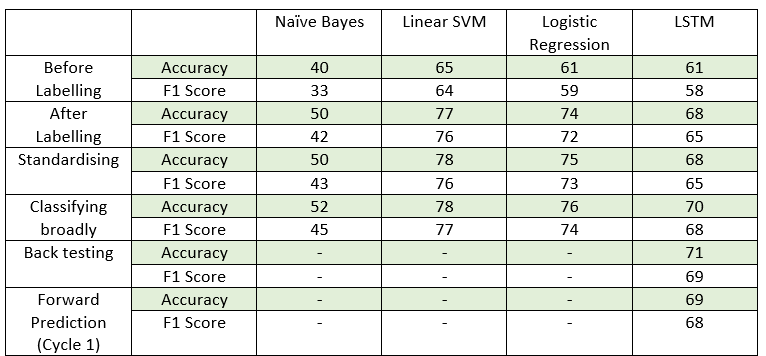

# Forward Predictions Cycle 2

For each cycle, we will use the model from the previous stage to forward predict the labels.

Then we will only look at rows with the difference below a certain threshold as the data is unseen. Inevitably, we might need to add new labels. 

With the modified labels, we will retrain the model.

We will use this model to backtest on the training set.

The threshold for this might not be similar to the threshold above. This is to ensure that the new labels are predicted correctly by the model.

Then, we will retrain the model with the updated labels.

For each cycle, we will be doing on 1 month of data.

In [ ]:
import pandas as pd

overall_df = pd.read_excel('Forward Predict Cycle 2.xlsx')

## Backtesting Part 1

### Pre-processing

Steps involved here:

    1. Clean the class labels

    2. Removing rows which have empty Item Name and Item Description

    3. Concatenating the Item Name and Item Description Columns so that we do not need to have 2 bags of words later.

    4. Text Cleaning

      - Remove Punctuation
      - Lowercase all the words
      - Tokenize the texts, meaning that each word will become a token
      - Removing stopwords. Stopwords are commonly used words such as 'the', 'she', 'he'.
      - Lemmatizing. Group words to a similar word. For example, 'good', 'better' and 'best' will be changed to 'good'.
      - Stemming. To convert the words to their root form. For example, 'eating' will be changed to 'eat'.
      - Removing special characters, such as '$', '%'
      - Removing numbers
      - Removing line breaks. They will appear as '\r' or '\n' in the text.
      - Removing single character. They are probably just typos.


Step 1: Cleaning of class labels

We noticed that there are some rows with spacing as well as \t and \n in the labels. We need to clean them so that the model will not treat the label with a spacing as a different label.

In [ ]:
for index, row in overall_df.iterrows():
  label = str(row['Original Label'])
  if '\t' in label:
    overall_df.at[index, 'Original Label'] = str(row['Original Label']).replace('\t', '')
  if '\n' in label:
    overall_df.at[index, 'Original Label'] = str(row['Original Label']).replace('\n', '')
  overall_df.at[index, 'Original Label'] = str(row['Original Label']).strip(' ')

The code below describes steps 2 and 3.

In [ ]:
texts = []
classes = []
for index, row in overall_df.iterrows():
  classname = row['Original Label']
  if len(str(row['Item Name'])) == 0 and len(str(row['Item Description'])) == 0: #whole row is empty
    continue
  if pd.isna(row['Item Description']): #keeping only 1 of the columns if the other column is empty
    text = str(row['Item Name'])
  elif pd.isna(row['Item Name']):
    text = str(row['Item Description'])
  else:
    text = str(row['Item Name']) + " " + str(row['Item Description']) #concatenate both text columns to form just 1 column
  if not pd.isna(classname) and not pd.isna(text): #only want rows with non-empty classes and non-empty text
    texts.append(text)
    classes.append(classname)

df = pd.DataFrame()
df['Class'] = classes
df['Text'] = texts

df.head()

Step 4: Text Cleaning

We will write a function so that it is easier to automate the text cleaning later.

In [ ]:
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
nltk.download('wordnet')

def text_cleaning(dataframe):
  new_df = pd.DataFrame()
  texts = []
  classes = []
  tokenizer = RegexpTokenizer(r'\w+')
  stopwords_lst = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()
  stemmer = PorterStemmer()
  for index, row in dataframe.iterrows():
    text = row['Text']
    #remove punctuation
    text = ''.join([i for i in text if i not in string.punctuation])
    #lowercase 
    text = ''.join([i.lower() for i in text])
    #tokenize
    text = ' '.join(tokenizer.tokenize(text))
    #remove stopwords
    text = ' '.join([i for i in text.split() if i not in stopwords_lst])
    #lemmatize
    text = ' '.join([lemmatizer.lemmatize(i) for i in text.split()])
    #stemming
    text = ' '.join([stemmer.stem(i) for i in text.split()])
    #remove special characters
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    #remove numbers
    text = ' '.join([i for i in text.split() if i.isalpha()])
    #remove line breaks
    text = text.replace('\n', " ")
    text = text.replace('\r', " ")
    #remove single character
    text = ' '.join([w for w in text.split() if len(w)>1] )
    classes.append(row['Class'])
    texts.append(text)
  new_df['Class'] = classes
  new_df['Text'] = texts
  return new_df

In [ ]:
cleaned_df = text_cleaning(df)

cleaned_df.head()

Load saved tokenizer and saved labels

In [ ]:
import pickle

#with open('backtesting_tokenizer.pickle', 'wb') as handle:
    #pickle.dump(tokenizer, handle)

with open('fp_cycle1_tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

#with open('labels.pickle', 'wb') as handle:
    #pickle.dump(tokenizer, handle)

with open('fp_cycle1_labels.pickle', 'rb') as handle:
    labels = pickle.load(handle)

Use tokenizer to convert the texts to sequences

In [ ]:
tokenizer.fit_on_texts(cleaned_df['Text'].values)

X = tokenizer.texts_to_sequences(cleaned_df['Text'].values)
X = pad_sequences(X, maxlen=250)

### Load LSTM model to make predictions

In [ ]:
from keras.models import load_model

# returns a compiled model identical to the previous one
model = load_model('fp_cycle1_lstm_model_threshold_20.hdf5')

Get predictions

In [ ]:
predictions = model.predict(X)

Retrieving the top 2 classes as well as the corresponding probabilities

We won't be matching the original labels to the predicted labels since the style of labelling is different. Rather, we will just be checking on the difference in probabilities between the top 2 predicted classes and decide which rows to look at.

In [ ]:
import numpy as np

top_classes = []
second_classes = []
top_probs = []
second_probs = []
differences = []
classes = []


for index, row in cleaned_df.iterrows():
  probs = probabilities[index]
  top_2 = np.argsort(probs)[-2:][::-1]
  top_2_labels = [labels[i] for i in top_2]
  top_classes.append(top_2_labels[0])
  second_classes.append(top_2_labels[1])
  difference = probs[top_2[0]] - probs[top_2[1]]
  top_probs.append(probs[top_2[0]])
  second_probs.append(probs[top_2[1]])
  differences.append(difference)
  classes.append(row['Class'])


overall_df['Original Class'] = classes
overall_df['1st Predicted Class'] = top_classes
overall_df['1st Predicted Probability'] = top_probs
overall_df['2nd Predicted Class'] = second_classes
overall_df['2nd Predicted Probability'] = second_probs
overall_df['Difference'] = differences
overall_df.head()

Get the statistical distribution of the differences. Then, we will decide on the threshold. 

In [ ]:
overall_df['Difference'].describe()

Save dataframe into an excel file

In [ ]:
overall_df.to_excel('Forward Predictions Cycle 2 Part 1.xlsx')

Then, we will now proceed to manual checking the labels. Then, we will retrain the LSTM model on y1 + 1 month of data. We have merged the fiscal y1 data with this month of data into the same excel file to make it more convenient.

## Retrain LSTM model

We will fit the entire dataset (y1 + 2 months) into the model to retrain it.

In [ ]:
overall_df = pd.read_excel('Forward Predictions Cycle 2 Part 1.xlsx')

labels_df = pd.read_excel('Forward Predictions Cycle 2 Part 1.xlsx', sheet_name = 'Labels Masterlist')
labels_dct = dict(zip(labels_df['Label'], labels_df['Code']))

### Pre-processing

Steps involved here:

    1. Clean the class labels

    2. Removing rows which have empty Item Name and Item Description

    3. Concatenating the Item Name and Item Description Columns so that we do not need to have 2 bags of words later.

    4. Text Cleaning

      - Remove Punctuation
      - Lowercase all the words
      - Tokenize the texts, meaning that each word will become a token
      - Removing stopwords. Stopwords are commonly used words such as 'the', 'she', 'he'.
      - Lemmatizing. Group words to a similar word. For example, 'good', 'better' and 'best' will be changed to 'good'.
      - Stemming. To convert the words to their root form. For example, 'eating' will be changed to 'eat'.
      - Removing special characters, such as '$', '%'
      - Removing numbers
      - Removing line breaks. They will appear as '\r' or '\n' in the text.
      - Removing single character. They are probably just typos.


Step 1: Cleaning of class labels

We noticed that there are some rows with spacing as well as \t and \n in the labels. We need to clean them so that the model will not treat the label with a spacing as a different label.

In [ ]:
for index, row in overall_df.iterrows():
  label = str(row['New Label'])
  if '\t' in label:
    overall_df.at[index, 'New Label'] = str(row['New Label']).replace('\t', '')
  if '\n' in label:
    overall_df.at[index, 'New Label'] = str(row['New Label']).replace('\n', '')
  overall_df.at[index, 'New Label'] = str(row['New Label']).strip(' ')

The code below describes steps 2 and 3.

In [ ]:
texts = []
classes = []
for index, row in overall_df.iterrows():
  classname = row['New Label']
  if len(str(row['Item Name'])) == 0 and len(str(row['Item Description'])) == 0: #whole row is empty
    continue
  if pd.isna(row['Item Description']): #keeping only 1 of the columns if the other column is empty
    text = str(row['Item Name'])
  elif pd.isna(row['Item Name']):
    text = str(row['Item Description'])
  else:
    text = str(row['Item Name']) + " " + str(row['Item Description']) #concatenate both text columns to form just 1 column
  if not pd.isna(classname) and not pd.isna(text): #only want rows with non-empty classes and non-empty text
    texts.append(text)
    classes.append(classname)

df = pd.DataFrame()
df['Class'] = classes
df['Text'] = texts

df.head()

Step 4: Text Cleaning

We will write a function so that it is easier to automate the text cleaning later.

In [ ]:
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
nltk.download('wordnet')

def text_cleaning(dataframe):
  new_df = pd.DataFrame()
  texts = []
  classes = []
  tokenizer = RegexpTokenizer(r'\w+')
  stopwords_lst = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()
  stemmer = PorterStemmer()
  for index, row in dataframe.iterrows():
    text = row['Text']
    #remove punctuation
    text = ''.join([i for i in text if i not in string.punctuation])
    #lowercase 
    text = ''.join([i.lower() for i in text])
    #tokenize
    text = ' '.join(tokenizer.tokenize(text))
    #remove stopwords
    text = ' '.join([i for i in text.split() if i not in stopwords_lst])
    #lemmatize
    text = ' '.join([lemmatizer.lemmatize(i) for i in text.split()])
    #stemming
    text = ' '.join([stemmer.stem(i) for i in text.split()])
    #remove special characters
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    #remove numbers
    text = ' '.join([i for i in text.split() if i.isalpha()])
    #remove line breaks
    text = text.replace('\n', " ")
    text = text.replace('\r', " ")
    #remove single character
    text = ' '.join([w for w in text.split() if len(w)>1] )
    classes.append(row['Class'])
    texts.append(text)
  new_df['Class'] = classes
  new_df['Text'] = texts
  return new_df

In [ ]:
cleaned_df = text_cleaning(df)

cleaned_df.head()

### Training LSTM model

In [ ]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential

Prepare the X and Y

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each row.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(cleaned_df['Text'].values)
word_index = tokenizer.word_index #this is important for evaluation of final test dataset

X = tokenizer.texts_to_sequences(cleaned_df['Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

In [ ]:
Y = pd.get_dummies(cleaned_df['Class']).values
print('Shape of label tensor:', Y.shape)

Use the main and excess indexes we have gotten earlier to split X and Y into the main inputs and the excess inputs

In [ ]:
X_main = X[main_idxs]
X_excess = X[excess_idxs]
Y_main = Y[main_idxs]
Y_excess = Y[excess_idxs]
print(X_main.shape)
print(X_excess.shape)
print(Y_main.shape)
print(Y_excess.shape)

Like before, only X_main will be split into train and test set

In [ ]:
corpus_train_mat = X_main[strat_train_set,] #can still use back the same indices from the earlier stratified train test split
corpus_test_mat = X_main[strat_test_set,]
y_train = Y_main[strat_train_set]
y_test = Y_main[strat_test_set]

Build LSTM Model

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(Y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Early stop the training if the validation loss did not improve in 10 epochs. We will also save the current training model if it has a lower validation loss than the previous saved one. 

In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
cp = ModelCheckpoint('fp_cycle2_lstm_model_threshold_20.hdf5',monitor='val_loss', save_best_only = True)

So for the training, we will first fit the excess data (below threshold) to the model first and let the model train on it for 10 epochs. Then, we will fit it to the bulk of the data with the test set.
At the end, we will fit the validation set to the model as well.

In [ ]:
#excess data train for 10 epochs

model.fit(X_excess, Y_excess, epochs = 10, batch_size = 32)

In [ ]:
epochs = 50
batch_size = 32

history = model.fit(corpus_train_mat, y_train, epochs=epochs, validation_data=(corpus_test_mat, y_test),
                    batch_size=batch_size,callbacks=[cp, es])

In [ ]:
from keras.models import load_model

# returns a compiled model identical to the previous one
model = load_model('fp_cycle2_lstm_model_threshold_20.hdf5')

In [ ]:
model.fit(corpus_test_mat, y_test, epochs = 10, batch_size = 32)

Save model

In [ ]:
model.save('fp_cycle2_lstm_model_threshold_20.hdf5')

Save tokenizer and labels

In [ ]:
import pickle

with open('fp_cycle2_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)

#with open('fp_cycle2_tokenizer.pickle', 'rb') as handle:
    #tokenizer = pickle.load(handle)

with open('fp_cycle2_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle)

#with open('fp_cycle2_labels.pickle', 'rb') as handle:
    #labels = pickle.load(handle)

## Backtesting Part 2

In [ ]:
overall_df = pd.read_excel('FP_cycle2.xlsx')

### Pre-processing

Steps involved here:

    1. Clean the class labels

    2. Removing rows which have empty Item Name and Item Description

    3. Concatenating the Item Name and Item Description Columns so that we do not need to have 2 bags of words later.

    4. Text Cleaning

      - Remove Punctuation
      - Lowercase all the words
      - Tokenize the texts, meaning that each word will become a token
      - Removing stopwords. Stopwords are commonly used words such as 'the', 'she', 'he'.
      - Lemmatizing. Group words to a similar word. For example, 'good', 'better' and 'best' will be changed to 'good'.
      - Stemming. To convert the words to their root form. For example, 'eating' will be changed to 'eat'.
      - Removing special characters, such as '$', '%'
      - Removing numbers
      - Removing line breaks. They will appear as '\r' or '\n' in the text.
      - Removing single character. They are probably just typos.


Step 1: Cleaning of class labels

We noticed that there are some rows with spacing as well as \t and \n in the labels. We need to clean them so that the model will not treat the label with a spacing as a different label.

In [ ]:
for index, row in overall_df.iterrows():
  label = str(row['New Label'])
  if '\t' in label:
    overall_df.at[index, 'New Label'] = str(row['New Label']).replace('\t', '')
  if '\n' in label:
    overall_df.at[index, 'New Label'] = str(row['New Label']).replace('\n', '')
  overall_df.at[index, 'New Label'] = str(row['New Label']).strip(' ')

The code below describes steps 2 and 3.

In [ ]:
texts = []
classes = []
for index, row in overall_df.iterrows():
  classname = row['New Label']
  if len(str(row['Item Name'])) == 0 and len(str(row['Item Description'])) == 0: #whole row is empty
    continue
  if pd.isna(row['Item Description']): #keeping only 1 of the columns if the other column is empty
    text = str(row['Item Name'])
  elif pd.isna(row['Item Name']):
    text = str(row['Item Description'])
  else:
    text = str(row['Item Name']) + " " + str(row['Item Description']) #concatenate both text columns to form just 1 column
  if not pd.isna(classname) and not pd.isna(text): #only want rows with non-empty classes and non-empty text
    texts.append(text)
    classes.append(classname)

df = pd.DataFrame()
df['Class'] = classes
df['Text'] = texts

df.head()

Step 4: Text Cleaning

We will write a function so that it is easier to automate the text cleaning later.

In [ ]:
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
nltk.download('wordnet')

def text_cleaning(dataframe):
  new_df = pd.DataFrame()
  texts = []
  classes = []
  tokenizer = RegexpTokenizer(r'\w+')
  stopwords_lst = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()
  stemmer = PorterStemmer()
  for index, row in dataframe.iterrows():
    text = row['Text']
    #remove punctuation
    text = ''.join([i for i in text if i not in string.punctuation])
    #lowercase 
    text = ''.join([i.lower() for i in text])
    #tokenize
    text = ' '.join(tokenizer.tokenize(text))
    #remove stopwords
    text = ' '.join([i for i in text.split() if i not in stopwords_lst])
    #lemmatize
    text = ' '.join([lemmatizer.lemmatize(i) for i in text.split()])
    #stemming
    text = ' '.join([stemmer.stem(i) for i in text.split()])
    #remove special characters
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    #remove numbers
    text = ' '.join([i for i in text.split() if i.isalpha()])
    #remove line breaks
    text = text.replace('\n', " ")
    text = text.replace('\r', " ")
    #remove single character
    text = ' '.join([w for w in text.split() if len(w)>1] )
    classes.append(row['Class'])
    texts.append(text)
  new_df['Class'] = classes
  new_df['Text'] = texts
  return new_df

In [ ]:
cleaned_df = text_cleaning(df)

cleaned_df.head()

### Making Predictions



Retrieve tokenizer and labels

In [ ]:
import pickle

#with open('fp_cycle2_tokenizer.pickle', 'wb') as handle:
    #pickle.dump(tokenizer, handle)

with open('fp_cycle2_tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

#with open('fp_cycle2_labels.pickle', 'wb') as handle:
    #pickle.dump(Y, handle)

with open('fp_cycle2_labels.pickle', 'rb') as handle:
    labels = pickle.load(handle)

Use tokenizer to convert the texts to sequences

In [ ]:
tokenizer.fit_on_texts(cleaned_df['Text'].values)

X = tokenizer.texts_to_sequences(cleaned_df['Text'].values)
X = pad_sequences(X, maxlen=250)

Load LSTM model

In [ ]:
from keras.models import load_model

# returns a compiled model identical to the previous one
model = load_model('fp_cycle2_lstm_model_threshold_20.hdf5')

Get predictions

In [ ]:
predictions = model.predict(X)

Retrieving the top 2 classes as well as the corresponding probabilities

We won't be matching the original labels to the predicted labels since the style of labelling is different. Rather, we will just be checking on the difference in probabilities between the top 2 predicted classes and decide which rows to look at.

In [ ]:
import numpy as np

top_classes = []
second_classes = []
top_probs = []
second_probs = []
differences = []
classes = []


for index, row in cleaned_df.iterrows():
  probs = probabilities[index]
  top_2 = np.argsort(probs)[-2:][::-1]
  top_2_labels = [labels[i] for i in top_2]
  top_classes.append(top_2_labels[0])
  second_classes.append(top_2_labels[1])
  difference = probs[top_2[0]] - probs[top_2[1]]
  top_probs.append(probs[top_2[0]])
  second_probs.append(probs[top_2[1]])
  differences.append(difference)
  classes.append(row['Class'])


overall_df['Original Class'] = classes
overall_df['1st Predicted Class'] = top_classes
overall_df['1st Predicted Probability'] = top_probs
overall_df['2nd Predicted Class'] = second_classes
overall_df['2nd Predicted Probability'] = second_probs
overall_df['Difference'] = differences
overall_df.head()

Get the statistical distribution of the differences. Then, we will decide on the threshold. 

In [ ]:
overall_df['Difference'].describe()

Save dataframe into an excel file

In [ ]:
overall_df.to_excel('Forward Predictions Cycle 2 Part 2.xlsx')

Then, we will now proceed to manual checking the labels. Once done, we will combine this with the y1 data again for convenience.

## Retrain LSTM model

We will fit the entire dataset (y1 + 2 months) into the model to retrain it.

In [ ]:
overall_df = pd.read_excel('Forward Predictions Cycle 2 Part 2.xlsx')

labels_df = pd.read_excel('Forward Predictions Cycle 2 Part 2.xlsx', sheet_name = 'Labels Masterlist')
labels_dct = dict(zip(labels_df['Label'], labels_df['Code']))

### Pre-processing

Steps involved here:

    1. Clean the class labels

    2. Removing rows which have empty Item Name and Item Description

    3. Concatenating the Item Name and Item Description Columns so that we do not need to have 2 bags of words later.

    4. Text Cleaning

      - Remove Punctuation
      - Lowercase all the words
      - Tokenize the texts, meaning that each word will become a token
      - Removing stopwords. Stopwords are commonly used words such as 'the', 'she', 'he'.
      - Lemmatizing. Group words to a similar word. For example, 'good', 'better' and 'best' will be changed to 'good'.
      - Stemming. To convert the words to their root form. For example, 'eating' will be changed to 'eat'.
      - Removing special characters, such as '$', '%'
      - Removing numbers
      - Removing line breaks. They will appear as '\r' or '\n' in the text.
      - Removing single character. They are probably just typos.


Step 1: Cleaning of class labels

We noticed that there are some rows with spacing as well as \t and \n in the labels. We need to clean them so that the model will not treat the label with a spacing as a different label.

In [ ]:
for index, row in overall_df.iterrows():
  label = str(row['New Label'])
  if '\t' in label:
    overall_df.at[index, 'New Label'] = str(row['New Label']).replace('\t', '')
  if '\n' in label:
    overall_df.at[index, 'New Label'] = str(row['New Label']).replace('\n', '')
  overall_df.at[index, 'New Label'] = str(row['New Label']).strip(' ')

The code below describes steps 2 and 3.

In [ ]:
texts = []
classes = []
for index, row in overall_df.iterrows():
  classname = row['New Label']
  if len(str(row['Item Name'])) == 0 and len(str(row['Item Description'])) == 0: #whole row is empty
    continue
  if pd.isna(row['Item Description']): #keeping only 1 of the columns if the other column is empty
    text = str(row['Item Name'])
  elif pd.isna(row['Item Name']):
    text = str(row['Item Description'])
  else:
    text = str(row['Item Name']) + " " + str(row['Item Description']) #concatenate both text columns to form just 1 column
  if not pd.isna(classname) and not pd.isna(text): #only want rows with non-empty classes and non-empty text
    texts.append(text)
    classes.append(classname)

df = pd.DataFrame()
df['Class'] = classes
df['Text'] = texts

df.head()

Step 4: Text Cleaning

We will write a function so that it is easier to automate the text cleaning later.

In [ ]:
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
nltk.download('wordnet')

def text_cleaning(dataframe):
  new_df = pd.DataFrame()
  texts = []
  classes = []
  tokenizer = RegexpTokenizer(r'\w+')
  stopwords_lst = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()
  stemmer = PorterStemmer()
  for index, row in dataframe.iterrows():
    text = row['Text']
    #remove punctuation
    text = ''.join([i for i in text if i not in string.punctuation])
    #lowercase 
    text = ''.join([i.lower() for i in text])
    #tokenize
    text = ' '.join(tokenizer.tokenize(text))
    #remove stopwords
    text = ' '.join([i for i in text.split() if i not in stopwords_lst])
    #lemmatize
    text = ' '.join([lemmatizer.lemmatize(i) for i in text.split()])
    #stemming
    text = ' '.join([stemmer.stem(i) for i in text.split()])
    #remove special characters
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    #remove numbers
    text = ' '.join([i for i in text.split() if i.isalpha()])
    #remove line breaks
    text = text.replace('\n', " ")
    text = text.replace('\r', " ")
    #remove single character
    text = ' '.join([w for w in text.split() if len(w)>1] )
    classes.append(row['Class'])
    texts.append(text)
  new_df['Class'] = classes
  new_df['Text'] = texts
  return new_df

In [ ]:
cleaned_df = text_cleaning(df)

cleaned_df.head()

### Training LSTM model

In [ ]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential

Prepare the X and Y

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each row.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(cleaned_df['Text'].values)
word_index = tokenizer.word_index #this is important for evaluation of final test dataset

X = tokenizer.texts_to_sequences(cleaned_df['Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

In [ ]:
Y = pd.get_dummies(cleaned_df['Class']).values
print('Shape of label tensor:', Y.shape)

Use the main and excess indexes we have gotten earlier to split X and Y into the main inputs and the excess inputs

In [ ]:
X_main = X[main_idxs]
X_excess = X[excess_idxs]
Y_main = Y[main_idxs]
Y_excess = Y[excess_idxs]
print(X_main.shape)
print(X_excess.shape)
print(Y_main.shape)
print(Y_excess.shape)

Like before, only X_main will be split into train and test set

In [ ]:
corpus_train_mat = X_main[strat_train_set,] #can still use back the same indices from the earlier stratified train test split
corpus_test_mat = X_main[strat_test_set,]
y_train = Y_main[strat_train_set]
y_test = Y_main[strat_test_set]

Build LSTM Model

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(Y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Early stop the training if the validation loss did not improve in 10 epochs. We will also save the current training model if it has a lower validation loss than the previous saved one. 

In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
cp = ModelCheckpoint('fp_cycle2_lstm_model_threshold_20.hdf5',monitor='val_loss', save_best_only = True)

So for the training, we will first fit the excess data (below threshold) to the model first and let the model train on it for 10 epochs. Then, we will fit it to the bulk of the data with the test set.
At the end, we will fit the validation set to the model as well.

In [ ]:
#excess data train for 10 epochs

model.fit(X_excess, Y_excess, epochs = 10, batch_size = 32)

The accuracy is 76%.

In [ ]:
epochs = 50
batch_size = 32

history = model.fit(corpus_train_mat, y_train, epochs=epochs, validation_data=(corpus_test_mat, y_test),
                    batch_size=batch_size,callbacks=[cp, es])

### Get the F1 Score

In [ ]:
from keras.models import load_model

# returns a compiled model identical to the previous one
model = load_model('fp_cycle2_lstm_model_threshold_20.hdf5')

Get predictions for test set

In [ ]:
predictions = model.predict(corpus_test_mat)

The model will return a list of probabilities for each row where each probability corresponds to the probability of that row belonging to this class. So we will take the class with the highest probability as the predicted class for that row. 

In [ ]:
import numpy as np

predictions_ans = []
for i in predictions:
  predictions_ans.append(np.argmax(i))

Since we encoded the Y by dummy variables earlier, each row will only have a 1 and the rest are 0. The 1 for that column will tell us the correct class for this row.

In [ ]:
correct_ans = []
for i in y_test:
  correct_ans.append(i.tolist().index(1))

Retrieving the F1 Score

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: " + str(accuracy_score(correct_ans, predictions_ans)))
print("Precision: " + str(precision_score(correct_ans, predictions_ans, average = 'weighted')))
print("Recall: " + str(recall_score(correct_ans, predictions_ans, average = 'weighted')))
print("F1 Score: " + str(f1_score(correct_ans, predictions_ans, average = 'weighted')))

### Fit the model to the validation set

In [ ]:
model.fit(corpus_test_mat, y_test, epochs = 10, batch_size = 32)

Save model

In [ ]:
model.save('fp_cycle2_lstm_model_threshold_20.hdf5')

Save tokenizer and labels

In [ ]:
import pickle

with open('fp_cycle2_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)

#with open('fp_cycle2_tokenizer.pickle', 'rb') as handle:
    #tokenizer = pickle.load(handle)

with open('fp_cycle2_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle)

#with open('fp_cycle2_labels.pickle', 'rb') as handle:
    #labels = pickle.load(handle)

In [ ]:
labels = pd.DataFrame.from_dict(labels_dct)
labels.to_excel('Labels Masterlist.xlsx')

As a summary, here are the accuracies and F1 scores we obtained so far:

1. Before Labelling
2. After Labelling
3. Standardising
4. Classifying broadly
5. Backtesting on y1 data
6. Forward prediction (cycle 1)
7. Forward prediction (cycle 2)

As mentioned earlier, due to the long computational time to get the predicted probabilities for the sklearn models, we will be focusing on LSTM only from backtesting onwards.

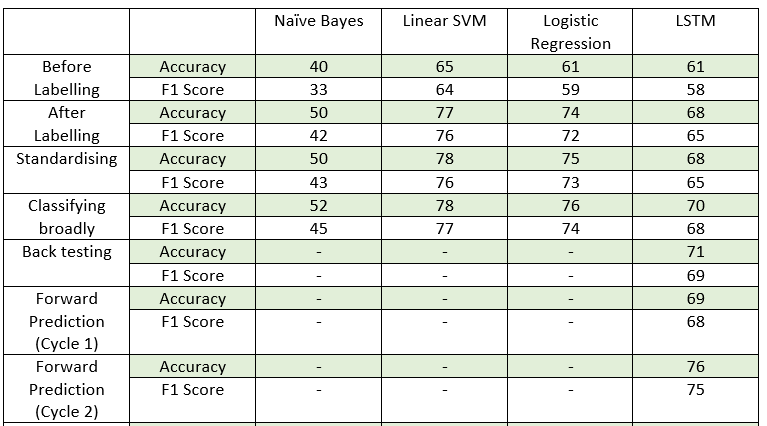

# Forward Predictions (Final evaluation)

This is the last forward prediction cycle, so we will only predict the labels, and then look at each row to determine if the top predicted label is correct or not. We will then use this to evaluate our model to get the accuracy and F1 Score.

In [ ]:
import pandas as pd

overall_df = pd.read_excel('Forward Predict Cycle 3.xlsx')

## Pre-processing

Steps involved here:

    1. Clean the class labels

    2. Removing rows which have empty Item Name and Item Description

    3. Concatenating the Item Name and Item Description Columns so that we do not need to have 2 bags of words later.

    4. Text Cleaning

      - Remove Punctuation
      - Lowercase all the words
      - Tokenize the texts, meaning that each word will become a token
      - Removing stopwords. Stopwords are commonly used words such as 'the', 'she', 'he'.
      - Lemmatizing. Group words to a similar word. For example, 'good', 'better' and 'best' will be changed to 'good'.
      - Stemming. To convert the words to their root form. For example, 'eating' will be changed to 'eat'.
      - Removing special characters, such as '$', '%'
      - Removing numbers
      - Removing line breaks. They will appear as '\r' or '\n' in the text.
      - Removing single character. They are probably just typos.


Step 1: Cleaning of class labels

We noticed that there are some rows with spacing as well as \t and \n in the labels. We need to clean them so that the model will not treat the label with a spacing as a different label.

In [ ]:
for index, row in overall_df.iterrows():
  label = str(row['Original Label'])
  if '\t' in label:
    overall_df.at[index, 'Original Label'] = str(row['Original Label']).replace('\t', '')
  if '\n' in label:
    overall_df.at[index, 'Original Label'] = str(row['Original Label']).replace('\n', '')
  overall_df.at[index, 'Original Label'] = str(row['Original Label']).strip(' ')

The code below describes steps 2 and 3.

In [ ]:
texts = []
classes = []
for index, row in overall_df.iterrows():
  classname = row['Original Label']
  if len(str(row['Item Name'])) == 0 and len(str(row['Item Description'])) == 0: #whole row is empty
    continue
  if pd.isna(row['Item Description']): #keeping only 1 of the columns if the other column is empty
    text = str(row['Item Name'])
  elif pd.isna(row['Item Name']):
    text = str(row['Item Description'])
  else:
    text = str(row['Item Name']) + " " + str(row['Item Description']) #concatenate both text columns to form just 1 column
  if not pd.isna(classname) and not pd.isna(text): #only want rows with non-empty classes and non-empty text
    texts.append(text)
    classes.append(classname)

df = pd.DataFrame()
df['Class'] = classes
df['Text'] = texts

df.head()

Step 4: Text Cleaning

We will write a function so that it is easier to automate the text cleaning later.

In [ ]:
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
nltk.download('wordnet')

def text_cleaning(dataframe):
  new_df = pd.DataFrame()
  texts = []
  classes = []
  tokenizer = RegexpTokenizer(r'\w+')
  stopwords_lst = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()
  stemmer = PorterStemmer()
  for index, row in dataframe.iterrows():
    text = row['Text']
    #remove punctuation
    text = ''.join([i for i in text if i not in string.punctuation])
    #lowercase 
    text = ''.join([i.lower() for i in text])
    #tokenize
    text = ' '.join(tokenizer.tokenize(text))
    #remove stopwords
    text = ' '.join([i for i in text.split() if i not in stopwords_lst])
    #lemmatize
    text = ' '.join([lemmatizer.lemmatize(i) for i in text.split()])
    #stemming
    text = ' '.join([stemmer.stem(i) for i in text.split()])
    #remove special characters
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    #remove numbers
    text = ' '.join([i for i in text.split() if i.isalpha()])
    #remove line breaks
    text = text.replace('\n', " ")
    text = text.replace('\r', " ")
    #remove single character
    text = ' '.join([w for w in text.split() if len(w)>1] )
    classes.append(row['Class'])
    texts.append(text)
  new_df['Class'] = classes
  new_df['Text'] = texts
  return new_df

In [ ]:
cleaned_df = text_cleaning(df)

cleaned_df.head()

Load saved tokenizer and saved labels

In [ ]:
import pickle

#with open('fp_cycle2_tokenizer.pickle', 'wb') as handle:
    #pickle.dump(tokenizer, handle)

with open('fp_cycle2_tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

#with open('fp_cycle2_labels.pickle', 'wb') as handle:
    #pickle.dump(tokenizer, handle)

with open('fp_cycle2_labels.pickle', 'rb') as handle:
    labels = pickle.load(handle)

Use tokenizer to convert the texts to sequences

In [ ]:
tokenizer.fit_on_texts(cleaned_df['Text'].values)

X = tokenizer.texts_to_sequences(cleaned_df['Text'].values)
X = pad_sequences(X, maxlen=250)

## Load LSTM model to make predictions

In [ ]:
from keras.models import load_model

# returns a compiled model identical to the previous one
model = load_model('fp_cycle2_lstm_model_threshold_20.hdf5')

Get predictions

In [ ]:
predictions = model.predict(X)

Get top predicted class based on highest probability

In [ ]:
import numpy as np

top_classes = []
second_classes = []
top_probs = []
second_probs = []
differences = []
classes = []


for index, row in cleaned_df.iterrows():
  probs = probabilities[index]
  top_2 = np.argsort(probs)[-2:][::-1]
  top_2_labels = [labels[i] for i in top_2]
  top_classes.append(top_2_labels[0])
  second_classes.append(top_2_labels[1])
  difference = probs[top_2[0]] - probs[top_2[1]]
  top_probs.append(probs[top_2[0]])
  second_probs.append(probs[top_2[1]])
  differences.append(difference)
  classes.append(row['Class'])


overall_df['Original Class'] = classes
overall_df['1st Predicted Class'] = top_classes
overall_df.head()

Then, we will look through each row and determine if the predicted label is correct or not. Then, we will be able to determine the accuracy and F1 Score.

## Determining Accuracy and F1 Score

In [ ]:
overall_df = pd.read_excel("Forward Predict Cycle 3.xlsx")

In [ ]:
correct ans = overall_df['Correct Label'].values
predictions_ans = overall_df['Predicted Label'].values

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: " + str(accuracy_score(correct_ans, predictions_ans)))
print("Precision: " + str(precision_score(correct_ans, predictions_ans, average = 'weighted')))
print("Recall: " + str(recall_score(correct_ans, predictions_ans, average = 'weighted')))
print("F1 Score: " + str(f1_score(correct_ans, predictions_ans, average = 'weighted')))

As a summary, here are the accuracies and F1 scores we have obtained:

1. Before Labelling
2. After Labelling
3. Standardising
4. Classifying broadly
5. Backtesting on y1 data
6. Forward prediction (cycle 1)
7. Forward prediction (cycle 2)
8. Forward prediction (final evaluation)

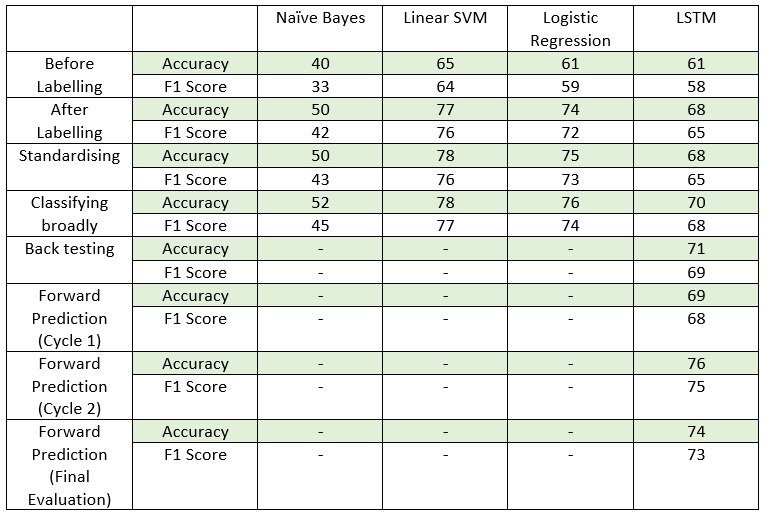

This concludes the end of the text classification component. For the other component which is dashboards, the coding part will involve the market basket analysis only, which will be elaborated in the next notebook.